In [1]:
from datetime import datetime
import datetime as dt
import pandas as pd
import numpy as np
import urllib.request, json
import scipy.stats as stats
import statsmodels.api as sm

from metloom.pointdata import MesowestPointData, SnotelPointData
# import pyet
import metpy.calc as calc
from metpy.units import units
from dataretrieval import nwis

import geopandas as gpd
import fiona
fiona.drvsupport.supported_drivers['KML'] = 'rw'
fiona.drvsupport.supported_drivers['KMZ'] = 'rw'
fiona.drvsupport.supported_drivers['LIBKML'] = 'rw'

import matplotlib.pyplot as plt

/home/dlhogan/.conda/envs/soil_moisture_env/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.11.1-CAPI-1.17.1). Conversions between both will be slow.
  warnings.warn(


### Functions for Use throughout notebook

In [2]:
def calc_net_lw_radiation(temperature, relative_humidity, elevation, dew_pt_temp=None):
    """Compute net longwave clear sky radiation from temperature measurements, relative humidy values and site elevation


    Args:
        temperature (array-like): mean daily temperatures (C)
        relative_humidity (array-like): mean relative humidity (%)
        elevation (float): site elevation (m)
        dew_pt_temp (array-like, optional): Dew point temperature, include if measured. Defaults to None.

    Returns:
        Series: net longwave radiations in W/m2
    """
    SIGMA = 5.67e-8
    CONSTANT = 40

    # Convert temperature to Kelvin
    temperature_K = temperature.to_xarray().squeeze()+273.15
    temperature_K.attrs = {'units':'K'}


    # Using Marks & Dozier, 1979 to calculate emissivity 
    T_prime = temperature_K + (0.0065 * elevation)
    T_prime.attrs = {'units':'K'}
    e_prime = relative_humidity*calc.saturation_vapor_pressure(T_prime)/100
    
    # Hydrostatic pressure
    standard_p = 101325*((293+(elevation*-0.0065))/293)**(-9.81*0.0299/(-.0065*8.314))
    # Emissivity estimate
    epsilon_atmos=(1.24 * (e_prime/T_prime)**(1/7) * (standard_p)/101300)

    # Longwave in estimate
    lw_in = epsilon_atmos * SIGMA * temperature_K**4 - CONSTANT

    # Calculate longwave out
    if dew_pt_temp is None:
        dew_pt_temp = calc.dewpoint_from_relative_humidity(temperature_K,(relative_humidity/100).to_xarray()).values
    lw_out = SIGMA*(dew_pt_temp+273.15)**4

    # Compute net longwave radiation
    rnet = lw_in - lw_out
    return rnet

def normalize_data(df):
    '''Normalized a pandas series'''
    norm = (df - df.mean())/df.std()
    if type(norm.index) is datetime:
        norm.index = norm.reset_index()
    else:
        norm.index = norm.index.astype(int)

    return norm

What I want is a figure to compare the peak swe with discharge (normalized)
- then I will have one legend for signal type (warm year, cold year, dry year, wet year, soil moisture is high or low)
- normalized sublimation estimate will be the size of each circle

# Groundwater data

In [3]:
# # Column names match well names
# col_names = ['ER-CPA1','ER-CPA2','ER-CPA3','ER-CPA4','ER-CPA5','ER-CPA6']
# # Data originated here: https://data.ess-dive.lbl.gov/view/doi%3A10.15485%2F1647041#ess-dive-313d6acde6c64a0-20200803T191803435
# # Get well data
# er_cpa1 = pd.read_csv('./data/er_groundwater_data/ER_CPA1.csv', index_col=0)['WLelevationMeter']
# er_cpa2 = pd.read_csv('./data/er_groundwater_data/ER_CPA2.csv', index_col=0)['WLelevationMeter']
# er_cpa3 = pd.read_csv('./data/er_groundwater_data/ER_CPA3.csv', index_col=0)['WLelevationMeter']
# er_cpa4 = pd.read_csv('./data/er_groundwater_data/ER_CPA4.csv', index_col=0)['WLelevationMeter']
# er_cpa5 = pd.read_csv('./data/er_groundwater_data/ER_CPA5.csv', index_col=0)['WLelevationMeter']
# er_cpa6 = pd.read_csv('./data/er_groundwater_data/ER_CPA6.csv', index_col=0)['WLelevationMeter']
# er_cpa6 = er_cpa6[~er_cpa6.index.duplicated()]
# # Get well info
# er_well_info = pd.read_csv('./data/er_groundwater_data/WellLocation_WLdataArchive2018.csv')

# # Put well data in list for addition to dictionary
# gw_data = [er_cpa1,
#             er_cpa6,
#             er_cpa3,
#             er_cpa4,
#             er_cpa5,
#             er_cpa6]
# # Create dictionary for names and data            
# col_names_dict = dict(zip(col_names,gw_data))
# # Concatenate dataframe
# er_dtw_df = pd.concat(col_names_dict, axis = 1).sort_index()
# # Compute depth to water from well elevation dataset
# for col in er_dtw_df.columns:
#     er_dtw_df[col] = er_well_info[er_well_info['Well Location ID']==col]['Elevation'].values - er_dtw_df[col]

# er_dtw_df.index = pd.to_datetime(er_dtw_df.index)
# # Save as a csv
# save_data = False
# if save_data:
#     er_dtw_df.to_csv('../data/er_groundwater_data/ER_CPA1-6_dtw.csv')

In [4]:
er_dtw_df = pd.read_csv('./data/er_groundwater_data/ER_CPA1-6_dtw.csv', index_col=0)
er_dtw_df.index = pd.to_datetime(er_dtw_df.index)
er_dtw_daily_df = er_dtw_df.groupby(er_dtw_df.index.date).mean()
# filter out days with less than 12 measurements
er_dtw_daily_df_filtered = er_dtw_daily_df[~(er_dtw_df.groupby(er_dtw_df.index.date).count() < 12)]
# Throw out days where the difference is greater than 2 standard deviations from the mean
er_dtw_daily_df_filtered.iloc[1:] =  er_dtw_daily_df_filtered.iloc[1:][er_dtw_daily_df.diff().iloc[1:]<er_dtw_daily_df.diff().std()*2]
er_dtw_daily_df_filtered.head()

,ER-CPA1,ER-CPA2,ER-CPA3,ER-CPA4,ER-CPA5,ER-CPA6
2015-10-11,0.903266,0.822709,0.932056,0.798641,0.878632,0.882709
2015-10-12,0.908891,0.827469,0.963234,0.808871,0.914216,0.887469
2015-10-13,0.913610,0.832949,0.968442,0.816287,0.949466,0.892949
2015-10-14,0.917422,0.841709,0.970056,0.824621,0.982893,0.901709
2015-10-15,0.920526,0.849657,0.971671,0.831631,1.012768,0.909657


Take a look at the spread of the data each year

/tmp/ipykernel_4058/173564726.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  er_dtw_daily_df_filtered.groupby(pd.Grouper(freq="Y")).boxplot(ax=ax);


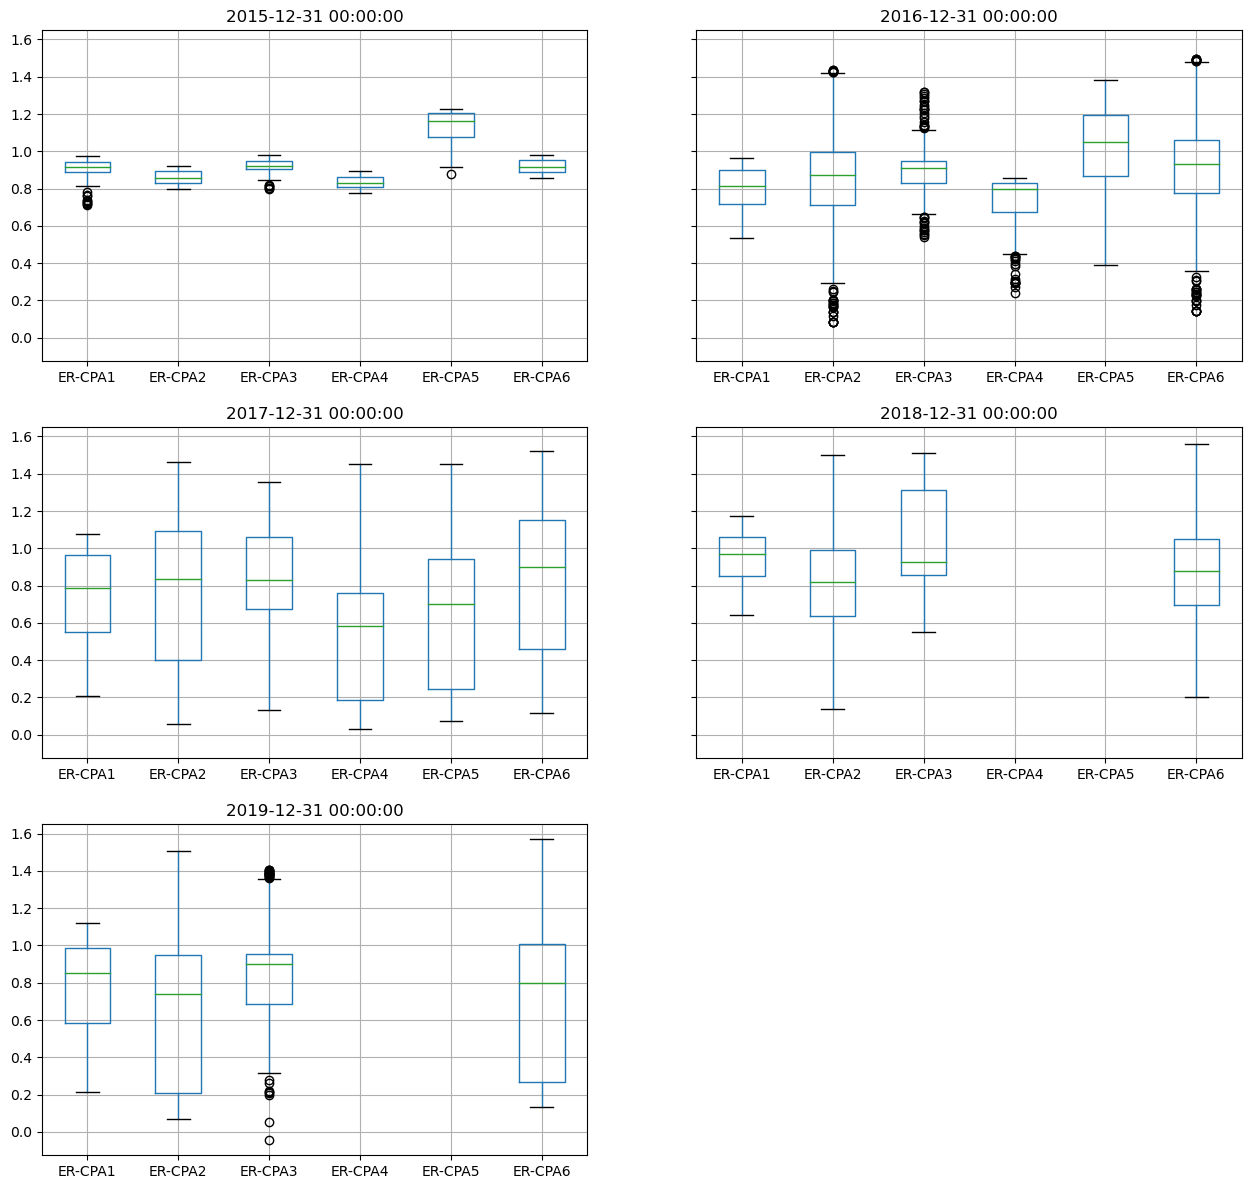

In [5]:
fig, ax=plt.subplots(figsize=(15,15))
er_dtw_daily_df_filtered.index = pd.to_datetime(er_dtw_daily_df_filtered.index)
er_dtw_daily_df_filtered.groupby(pd.Grouper(freq="Y")).boxplot(ax=ax);

# Streamflow Data

- grab East River at Almont daily mean
- grab East River at Cement Creek daily mean

See how well they correlate to one another

In [6]:
# get streamflow data from east river at almont
east_river_discharge_almont_dv = nwis.get_record('09112500', start='1936-10-1', end='2021-10-1',service='dv')['00060_Mean']
east_river_discharge_almont_dv = east_river_discharge_almont_dv[east_river_discharge_almont_dv>=0].iloc[:-1]
east_river_discharge_almont_dv.index = east_river_discharge_almont_dv.index.date

# get daily streamflow data from east river at cement creek
east_river_discharge_cc_dv = nwis.get_record('09112200', start='1993-10-1',end='2021-09-30', service='dv')['00060_Mean']
east_river_discharge_cc_dv = east_river_discharge_cc_dv[east_river_discharge_cc_dv>=0]
east_river_discharge_cc_dv.index = east_river_discharge_cc_dv.index.date

# Remove nans
east_river_discharge_almont_dv[east_river_discharge_almont_dv<0] = np.nan
east_river_discharge_cc_dv[east_river_discharge_cc_dv<0] = np.nan

# strong agreement between 2 locations
r_value = stats.linregress(east_river_discharge_cc_dv,east_river_discharge_almont_dv.loc[east_river_discharge_cc_dv.index])[2]
print(f'R2 = {r_value**2}') # very good agreement between these locations

# Annual mean discharge
east_river_discharge_almont = nwis.get_stats('09112500',statReportType='annual',statTypeCd='mean')[0]
east_river_discharge_almont = east_river_discharge_almont.set_index('year_nu', drop=True)
east_river_discharge_almont_post_1992 = east_river_discharge_almont[east_river_discharge_almont.index>1991]['mean_va']

R2 = 0.9898149678223775


Shorten the time series and grab monthly data

In [7]:
# Pull in data
east_river_discharge_almont_dv = nwis.get_record('09112500', start='1991-10-1', service='dv')['00060_Mean']

# Filter to timing
east_river_discharge_almont_dv = east_river_discharge_almont_dv.loc[:'2022-10-1']
east_river_discharge_almont_dv = east_river_discharge_almont_dv[east_river_discharge_almont_dv>=0]

# Create monthly means and replace index
east_river_discharge_almont_monthly = east_river_discharge_almont_dv.groupby(pd.Grouper(freq='M')).mean()
east_river_discharge_almont_dv.index = pd.to_datetime(east_river_discharge_almont_dv.index).date

# Rename columns and add water year
east_river_discharge_almont_monthly.name = 'mean_discharge'
east_river_discharge_almont_monthly = east_river_discharge_almont_monthly.to_frame()
east_river_discharge_almont_monthly['water_yr'] = east_river_discharge_almont_monthly.index.year.where(east_river_discharge_almont_monthly.index.month < 10, east_river_discharge_almont_monthly.index.year + 1)

# Create annual product
east_river_discharge_almont_annual = east_river_discharge_almont_monthly.groupby(east_river_discharge_almont_monthly['water_yr']).mean()

In [8]:
# Another way to do this
# Grabs simple monthly mean for ease of use
east_river_discharge_almont = nwis.get_stats('09112500',statReportType='monthly',statTypeCd='mean')[0]

# Adds water year as a column
east_river_discharge_almont['water_yr'] =  east_river_discharge_almont['year_nu'].where(east_river_discharge_almont.month_nu < 10, east_river_discharge_almont['year_nu'] + 1)
east_river_discharge_almont_mean = east_river_discharge_almont[['mean_va', 'water_yr']].groupby(east_river_discharge_almont['water_yr']).mean()

east_river_discharge_almont_mean.set_index('water_yr', drop=True)
east_river_discharge_almont_post_1992 = east_river_discharge_almont_mean[east_river_discharge_almont_mean.index>1991]['mean_va']

In [9]:
# need to drop 2023 because we do not have all the monthly mean data
east_river_discharge_almont_post_1992 = east_river_discharge_almont_annual.drop(2023)

Looks like the Almont location works pretty great on our 2019 data, lets see how it looks predicting the 2020 data

So in all, this looks to be a decent model for predicting the streamflow at the Pumphouse, which is the outflow of our region, so lets extrapolate these values back to 1993 so that we can estimate the Q in terms of mm/year

Now we have a datset of estimated streamflow at the pumphouse informed from the relationship of the 2019 data going back to 1936

### Looking into Basin sizes
This is the Upper East River basin, which is a combination of a few subbasins as discussed in Carrol et al 2018. The lower boundary at the exit is the location of the pumphouse, where we have daily discharge for WY 2018 and 2019. Lets build a linear model from the WY 2019 data to see how well we can match using the data from the East River at the confluence with Cement Creek, and then also test with the measurement at Almont. These are pretty much interchangable, so maybe I'll inform with the Almont data

Now lets get the area of our upper basin. It evalates to 84.72 square KM

### Snotel Data from Butte, Park Cone, and Schofield Pass

In [10]:
# Pull Butte snotel data
snotel_point = SnotelPointData("380:CO:SNTL", "Butte")
butte_sntl = snotel_point.get_daily_data(
    datetime(1991, 1, 1), datetime(2022, 9, 30),
    [snotel_point.ALLOWED_VARIABLES.PRECIPITATION,
     snotel_point.ALLOWED_VARIABLES.PRECIPITATIONACCUM,
     snotel_point.ALLOWED_VARIABLES.SNOWDEPTH,
     snotel_point.ALLOWED_VARIABLES.SWE,
     snotel_point.ALLOWED_VARIABLES.TEMP,
     snotel_point.ALLOWED_VARIABLES.RH]
)
butte_sntl = butte_sntl.droplevel(1)

# Add water year
butte_sntl['water_year'] =  butte_sntl.index.year.where(butte_sntl.index.month < 10, butte_sntl.index.year + 1)

# Compute max swe for each water year and normalize
butte_sntl_peaks_post1992 = butte_sntl.groupby('water_year')['SWE'].max()
butte_sntl_peaks_post1992_norm = (butte_sntl_peaks_post1992 - butte_sntl_peaks_post1992.mean())/butte_sntl_peaks_post1992.std()
# Get accumulated precip from the gage
butte_accum_precip = butte_sntl.groupby('water_year')['ACCUMULATED PRECIPITATION'].max()

# Get dates of max swe
butte_sntl.index = pd.to_datetime(butte_sntl.index)
max_swe_dates = butte_sntl['SWE'].groupby(butte_sntl.index.year).idxmax()

No RELATIVE HUMIDITY found for Butte


In [11]:
# # Pull Butte snotel data
# snotel_point = SnotelPointData("680:CO:SNTL", "Park Cone")
# park_cone_sntl = snotel_point.get_daily_data(
#     datetime(1991, 1, 1), datetime(2022, 9, 30),
#     [snotel_point.ALLOWED_VARIABLES.PRECIPITATION,
#      snotel_point.ALLOWED_VARIABLES.PRECIPITATIONACCUM,
#      snotel_point.ALLOWED_VARIABLES.SNOWDEPTH,
#      snotel_point.ALLOWED_VARIABLES.SWE,
#      snotel_point.ALLOWED_VARIABLES.TEMP,
#      snotel_point.ALLOWED_VARIABLES.RH]
# )
# park_cone_sntl = park_cone_sntl.droplevel(1)

# # Add water year
# park_cone_sntl['water_year'] =  park_cone_sntl.index.year.where(park_cone_sntl.index.month < 10, park_cone_sntl.index.year + 1)

# # Pull in park_cone Snotel Data
# park_cone_sntl = pd.read_csv('./data/snotel/park_cone_sntl_1991_2021.csv')

# # Compute max swe for each water year and normalize
# park_cone_sntl_peaks_post1992 = park_cone_sntl.groupby('water_year')['SWE'].max()
# park_cone_sntl_peaks_post1992_norm = (park_cone_sntl_peaks_post1992 - park_cone_sntl_peaks_post1992.mean())/park_cone_sntl_peaks_post1992.std()
# # Get accumulated precip from the gage
# park_cone_accum_precip = park_cone_sntl.groupby('water_year')['ACCUMULATED PRECIPITATION'].max()

# # Get dates of max swe
# park_cone_sntl.index = pd.to_datetime(park_cone_sntl.index)
# max_swe_dates = park_cone_sntl['SWE'].groupby(park_cone_sntl.index.year).idxmax()

Lets also grab the Schofield Pass data since it is at the top of our Basin

In [12]:
# snotel_point = SnotelPointData("737:CO:SNTL", "Schofield Pass")
# schofield_sntl = snotel_point.get_daily_data(
#     datetime(1991, 1, 1), datetime(2022, 9, 30),
#     [snotel_point.ALLOWED_VARIABLES.PRECIPITATION,
#      snotel_point.ALLOWED_VARIABLES.PRECIPITATIONACCUM,
#      snotel_point.ALLOWED_VARIABLES.SNOWDEPTH,
#      snotel_point.ALLOWED_VARIABLES.SWE,
#      snotel_point.ALLOWED_VARIABLES.TEMP,
#      snotel_point.ALLOWED_VARIABLES.RH]
# )
# schofield_sntl = schofield_sntl.droplevel(1)

# # Add water year
# schofield_sntl['water_year'] =  schofield_sntl.index.year.where(schofield_sntl.index.month < 10, schofield_sntl.index.year + 1)

In [13]:
# # Compute max swe for each water year and normalize
# schofield_sntl_peaks_post1992 = schofield_sntl.groupby('water_year')['SWE'].max()
# schofield_sntl_peaks_post1992_norm = (schofield_sntl_peaks_post1992 - schofield_sntl_peaks_post1992.mean())/schofield_sntl_peaks_post1992.std()
# # Get accumulated precip from the gage
# schofield_accum_precip = schofield_sntl.groupby('water_year')['ACCUMULATED PRECIPITATION'].max()

# # Get dates of max swe
# schofield_sntl.index = pd.to_datetime(schofield_sntl.index)
# max_swe_dates = schofield_sntl['SWE'].groupby(schofield_sntl.index.year).idxmax()

In [14]:
# snowcourse_point = SnotelPointData("07L01:CO:SNOW", "CrestedButte")
# crested_butte_df = snowcourse_point.get_snow_course_data(datetime(1936,2,1),datetime(2022,9,30), [snowcourse_point.ALLOWED_VARIABLES.SWE]).droplevel(1)

# # Get water year for Crested Butte data
# crested_butte_df['water_year'] =  crested_butte_df.index.year.where(crested_butte_df.index.month < 10, crested_butte_df.index.year + 1).astype(int)

# # Calculate max swe (mm)
# crested_butte_max_swe_mm = crested_butte_df['SWE'].groupby(crested_butte_df.index.year).max()

# # Fill in missing point with nearby snow course
# crested_butte_max_swe_mm[2001]=13.3
# crested_butte_max_swe_mm[2002]=9.0
# crested_butte_max_swe_mm[2003]=15.3
# crested_butte_max_swe_mm = crested_butte_max_swe_mm.sort_index()
# # This gives us approximate max SWE going back to 1936

Looking at how well these different locations for snow align with respect to max SWE. Not terrible, but not great either...

In [15]:
# df=pd.DataFrame([butte_sntl_peaks_post1992,
#                 park_cone_sntl_peaks_post1992,
#                 schofield_sntl_peaks_post1992,
#                 crested_butte_max_swe_mm.loc[1992:]]).T
# df.columns =['butte','park_cone','schofield','snow_course']                          
# df.corr()

Look at precipitation from NARR and how each of the locations compare to each other, if it looks good, we can use this accumulated precip with the snow course to go back to 1980

In [16]:
# import xarray as xr
# ds = xr.open_dataset('./data/met/NARR_apcp_1980_2022.nc')
# ds_mean = ds.isel(x=1,y=2)
# df_mean = ds_mean.to_pandas()
# df_mean['WY'] = df_mean.index.year.where(df_mean.index.month < 10, df_mean.index.year + 1).astype(int)
# df_mean_accum = df_mean['apcp'].groupby(df_mean['WY']).sum()

# narr_precip = pd.read_csv('./data/met/narr_precip_1980_2022.csv')
# narr_precip = narr_precip.set_index(narr_precip['Unnamed: 0'])

Let's grab our taylor park precipitation as well and the gunnison long term measurements

In [17]:
# # Get data and filter appropriately
# taylor_park_df = pd.read_csv('data/met/taylor_park_daily_met.txt',sep='\s+')
# taylor_park_df = taylor_park_df.set_index('Date')
# taylor_park_df = taylor_park_df.replace(-9999,np.nan)
# taylor_park_df.index = pd.to_datetime(taylor_park_df.index)
# taylor_park_df['Year'] =  taylor_park_df.index.year.where(taylor_park_df.index.month < 10, taylor_park_df.index.year + 1)
# taylor_park_df = taylor_park_df.rename(columns={'Year':'Water_Yr'})

# taylor_park_accum_precip = taylor_park_df['pcpn'].groupby(taylor_park_df['Water_Yr']).sum()

### Read in Gunnison met data going back to 1910, not sure if needed.

In [18]:
# gunnison_df = pd.read_json('./data/met/gunnison_met_1910.json')

# # Fix and convert max temp 
# gunnison_df['maxt'] = (gunnison_df['maxt'].replace({'M':np.nan,'-0':np.nan}).astype(float) - 32) * 5/9
# # Fix and convert min temp

# gunnison_df['mint'] = (gunnison_df['mint'].replace({'M':np.nan,'-0':np.nan}).astype(float) - 32) * 5/9
# # Fix and convert precip
# gunnison_df['pcpn'] = gunnison_df['pcpn'].str.replace("A","")
# gunnison_df['pcpn'] = gunnison_df['pcpn'].replace({'M':np.nan,'S':np.nan,'T':'0'}).astype(float) * 25.4
# # Fix and convert snow
# gunnison_df['snow'] = gunnison_df['snow'].str.replace("A","")
# gunnison_df['snow'] = gunnison_df['snow'].replace({'M':np.nan,'S':np.nan,'T':'0'}).astype(float) * 25.4

# gunnison_df.set_index('gunnison 3 sw', inplace=True)
# gunnison_df.index = pd.to_datetime(gunnison_df.index)
# gunnison_df['water_year'] =  gunnison_df.index.year.where(gunnison_df.index.month < 10, gunnison_df.index.year + 1)
# gunnison_accum_precip = gunnison_df['pcpn'].groupby(gunnison_df['water_year']).sum()

# winter_gunnison_df = gunnison_df.loc[(gunnison_df.index.month) < 5 | ((gunnison_df.index.month == 12) & (gunnison_df.index.day > 21)) ]

In [19]:
# winter_gunnison_df['avgt'] = (winter_gunnison_df['maxt'] + winter_gunnison_df['mint'])/2
# winter_gunnison_df['maxt'].groupby(winter_gunnison_df.index.year).mean().plot()

In [20]:
# df=pd.DataFrame([butte_accum_precip,
#                 park_cone_accum_precip,
#                 schofield_accum_precip,
#                 taylor_park_accum_precip.loc[1992:]/25.4,
#                 gunnison_accum_precip.loc[1992:]/25.4,
#                 df_mean_accum.loc[1992:]/25.4*2,
#                 narr_precip['narr_precip_totals_mm'].loc[1992:]/25.4*2]).T
# df.columns =['butte','park_cone','schofield','taylor_park','gunnison','narr_onecell', 'narr_all_cells']                          
# df.corr()

Taylor Park is not a very good station for precipitation and neither is Gunnison, but NARR precipitaiton from the specific cell we want does an okay job with the local stations. It gets worse the higher up we go, but that is because of basin averaging. If we took the mean elevation and used a lapse rate to compute the estimate each level, it may perform better. Multiplying this by 2 does seem to fit somehwhere between the measured values

In [21]:
def norm(df):
    norm_df = (df - df.min())/(df.max()-df.min())
    return norm_df

### Moving onto Snow Fraction

In [22]:
# # Take a look at how snow fraction and discharge align with each other
# # Getting the mean precip between butte and schofield
# mean_annual_precip = ((butte_accum_precip + schofield_accum_precip)/2)*25.4 # now in mm/year
# mean_annual_precip_narr = narr_precip['narr_precip_totals_mm']*2
# # Now converting our east river pumphouse discahrge to mm/year from the basin area
# er_ph_annual_q_mm = er_ph_annual_q * (3600*24*365) / upper_er_area * 1000 # now in mm/year

# # computing the snow fraction for each of these locations
# snow_frac_butte = butte_sntl_peaks_post1992/butte_accum_precip
# snow_frac_park_cone = park_cone_sntl_peaks_post1992/park_cone_accum_precip
# snow_frac_schofield_pass = schofield_sntl_peaks_post1992/schofield_accum_precip
# snow_frac_snowcourse = crested_butte_max_swe_mm.loc[mean_annual_precip_narr.index]/mean_annual_precip_narr
# # Index masking values and excluding 2015 due to the high flows from the summer (anomolously large summer monsoon)
# idx_mask = np.arange(1992,2022,1)
# idx_mask = idx_mask[idx_mask != 2015]

# fig, axs = plt.subplots(2, figsize=(12,6))
# axs[0].scatter(norm(snow_frac_butte.loc[idx_mask]),er_ph_annual_q_mm.loc[idx_mask]/mean_annual_precip.loc[idx_mask], label='Butte - elevation 10200 ft')
# axs[0].scatter(norm(snow_frac_park_cone.loc[idx_mask]),er_ph_annual_q_mm.loc[idx_mask]/mean_annual_precip.loc[idx_mask], label='Park Cone - elevation 9621 ft')
# axs[0].scatter(norm(snow_frac_schofield_pass.loc[idx_mask]),er_ph_annual_q_mm.loc[idx_mask]/mean_annual_precip.loc[idx_mask], label='Schofield Pass - elevation 10653 ft')
# axs[0].scatter(norm(snow_frac_snowcourse.loc[mean_annual_precip_narr.index]),er_ph_annual_q_mm.loc[mean_annual_precip_narr.index]/mean_annual_precip_narr, label='CB Snow Course - elevation 8920 ft')

# axs[0].legend(ncol=2, bbox_to_anchor=(0.8,1.25))
# # stats.linregress(snow_frac.loc[1992:2021],er_ph_annual_q/butte_accum_precip.loc[1992:2021])
# axs[0].set_xlabel('Normalized Snow Fraction (removed 2015)')
# axs[0].set_ylabel('Mean Discharge/Precipitation')

# axs[1].plot(snow_frac_butte.loc[idx_mask].index, norm(snow_frac_butte.loc[idx_mask]), label='Butte - elevation 10200 ft')
# axs[1].plot(snow_frac_park_cone.loc[idx_mask].index, norm(snow_frac_park_cone.loc[idx_mask]), label='Park Cone - elevation 9621 ft')
# axs[1].plot(snow_frac_schofield_pass.loc[idx_mask].index, norm(snow_frac_schofield_pass.loc[idx_mask]), label='Schofield Pass - elevation 10653 ft')
# axs[1].plot(snow_frac_snowcourse.index, norm(snow_frac_snowcourse), label='CB Snow Course - elevation 8920 ft')
# axs[1].legend()


In [23]:
# plt.plot(norm(snow_frac_butte.loc[idx_mask]),er_ph_annual_q_mm.loc[idx_mask]/mean_annual_precip.loc[idx_mask], label='Butte - elevation 10200 ft')
# # plt.plot(norm(snow_frac_park_cone.loc[idx_mask]),er_ph_annual_q_mm.loc[idx_mask]/mean_annual_precip.loc[idx_mask], label='Park Cone - elevation 9621 ft')
# plt.plot(norm(snow_frac_schofield_pass.loc[idx_mask]),er_ph_annual_q_mm.loc[idx_mask]/mean_annual_precip.loc[idx_mask], label='Schofield Pass - elevation 10653 ft')
# plt.plot(norm(snow_frac_snowcourse.loc[mean_annual_precip_narr.index]),er_ph_annual_q_mm.loc[mean_annual_precip_narr.index]/mean_annual_precip_narr, label='CB Snow Course - elevation 8920 ft')

Strong relationship between discharge and precipitation

### Look at the timing of liquid precipitation for each year

In [24]:
# butte_no_snow_precip = butte_sntl[(butte_sntl['SWE']==0) | (butte_sntl['AIR TEMP'] >= 34)][['PRECIPITATON','water_year']]
# butte_no_snow_precip['year'] = butte_no_snow_precip.index.year
# butte_no_snow_precip_sumfall = butte_no_snow_precip[butte_no_snow_precip.index.month.isin([9,10,11])]
# butte_no_snow_precip_springsum = butte_no_snow_precip[butte_no_snow_precip.index.month.isin([4,5,6])]
# spring_total = []
# fall_total = []
# butte_no_snow_precip['doy'] = butte_no_snow_precip.index.dayofyear
# ratios = []
# fig, ax = plt.subplots(figsize=(20,10),)
# for i,year in enumerate(butte_no_snow_precip.index.year.unique()):
#         sumfall_total = butte_no_snow_precip_sumfall[butte_no_snow_precip_sumfall.index.year==year].sum()
#         springsum_total = butte_no_snow_precip_springsum[butte_no_snow_precip_springsum.index.year==year].sum()
#         p1 = ax.bar(year,springsum_total['PRECIPITATON'], color='g', label='Summer Precip Total', alpha=0.7, ec='k', lw=2)
#         p2 = ax.bar(year,sumfall_total['PRECIPITATON'], bottom=springsum_total['PRECIPITATON'], color='brown', label='Spring Precip Total', alpha=0.7, ec='k', lw=2)

#         ax.bar_label(p1, label_type='center')
#         ax.bar_label(p2, label_type='center')
#         spring_total.append(springsum_total['PRECIPITATON'])
#         fall_total.append(sumfall_total['PRECIPITATON'])
#         ratios.append(springsum_total['PRECIPITATON']/sumfall_total['PRECIPITATON'])
#         if springsum_total['PRECIPITATON']/sumfall_total['PRECIPITATON'] > 0.75:
#                 ax.bar_label(p2, labels = np.round(np.array([springsum_total['PRECIPITATON']/sumfall_total['PRECIPITATON']]),2), weight='bold', color='red', size=12)
#         else:
#                 ax.bar_label(p2, labels = np.round(np.array([springsum_total['PRECIPITATON']/sumfall_total['PRECIPITATON']]),2), size=12)
#         if i == 0:
#                 ax.legend(fontsize=12)
# ax.set_xlabel('Year',size=20)
# ax.set_ylabel('Accumulated Precipitation (Non-Snow)')

### Plot all our data for dates we have alignment (Water Years 2016-2019)

In [25]:
east_river_discharge_almont_dv.index = pd.to_datetime(east_river_discharge_almont_dv.index).date
non_snow_precip = butte_sntl[(butte_sntl['SWE']==0) | (butte_sntl['AIR TEMP'] >= 35)]['PRECIPITATON']

In [26]:
cols = er_dtw_daily_df_filtered.columns

In [27]:
# Load in wrf_climatology netcdf 
import xarray as xr
wrf_climatology_ds = xr.open_dataset('/storage/dlhogan/sos/data/wrf_climatology.nc')
# Adding WY
wrf_climatology_ds = wrf_climatology_ds.assign_coords({'WY':wrf_climatology_ds.XTIME.dt.year.where(wrf_climatology_ds.XTIME.dt.month < 10, wrf_climatology_ds.XTIME.dt.year + 1)})

In [28]:
monthly_precipitation = butte_sntl.loc[dt.date(2016,10,1):dt.date(2017,9,30)]['PRECIPITATON'].groupby(lambda x: x.month).sum()*25.4
# reorder the axis from 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9
monthly_precipitation = monthly_precipitation.reindex([10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9])
# change axis to span october 2016 to september 2017
monthly_precipitation.index = pd.date_range(dt.date(2016,10,1), dt.date(2017,9,30), freq='MS')

monthly_precipitation_2018 = butte_sntl.loc[dt.date(2017,10,1):dt.date(2018,9,30)]['PRECIPITATON'].groupby(lambda x: x.month).sum()*25.4
# reorder the axis from 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9
monthly_precipitation_2018 = monthly_precipitation_2018.reindex([10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9])
# change axis to span october 2016 to september 2017
monthly_precipitation_2018.index = pd.date_range(dt.date(2017,10,1), dt.date(2018,9,30), freq='MS')

/tmp/ipykernel_4058/682842624.py:1: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  monthly_precipitation = butte_sntl.loc[dt.date(2016,10,1):dt.date(2017,9,30)]['PRECIPITATON'].groupby(lambda x: x.month).sum()*25.4
/tmp/ipykernel_4058/682842624.py:7: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  monthly_precipitation_2018 = butte_sntl.loc[dt.date(2017,10,1):dt.date(2018,9,30)]['PRECIPITATON'].groupby(lambda x: x.month).sum()*25.4


In [29]:
et_2017 = wrf_climatology_ds.where(wrf_climatology_ds['EAST_MASK']==True).sel(XTIME=slice('2016-9-30','2018-10-1'))['ET_rate'].mean(dim=['south_north','west_east'])
et_daily_2017 = et_2017.resample(XTIME='1D').interpolate("cubic")/30

et_2018 = wrf_climatology_ds.where(wrf_climatology_ds['EAST_MASK']==True).sel(XTIME=slice('2017-9-30','2018-10-1'))['ET_rate'].mean(dim=['south_north','west_east'])
et_daily_2018 = et_2018.resample(XTIME='1D').interpolate("cubic")/30


In [31]:
pet_ds_monthly = xr.open_dataset('../Upper_CO_Analysis/data/etdata/east_river_terraclime_pet_monthly.nc').pet
pet_ds = xr.open_dataset('../Upper_CO_Analysis/data/etdata/east_river_terraclime_pet.nc')
pet_ds_2017 = pet_ds.sel(time=slice('2015-10-01', '2018-10-01')).pet

ppt_ds_monthly = xr.open_dataset('../Upper_CO_Analysis/data/precipdata/east_river_terraclime_ppt_monthly.nc').ppt

Text(0.5, 1.0, 'East River Basin Conditions for Water Year 2017')

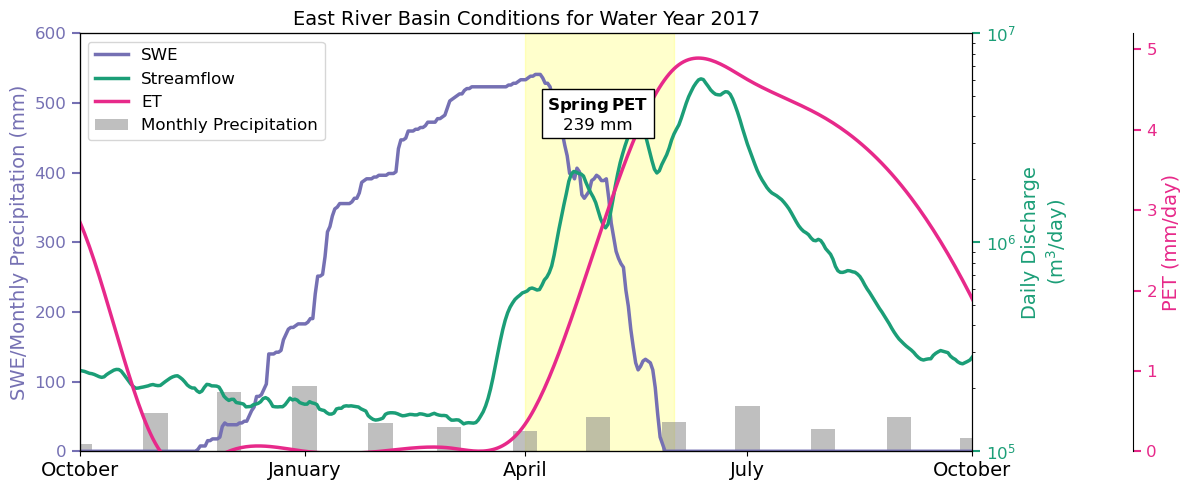

In [54]:
import pytz
fig, ax = plt.subplots(nrows=1,figsize=(12,5), tight_layout=True)
idx_mask = (east_river_discharge_almont_dv.index>dt.date(2014,10,1)) & (east_river_discharge_almont_dv.index<dt.date(2021,10,17))
colors=['#1b9e77',
        '#d95f02',
        '#7570b3',
        '#e7298a']
labels = ['Oct 2015', 'Oct 2016','Oct 2017','Oct 2018','Oct 2019','Oct 2020','Oct 2021']
locs = [dt.date(2015,10,1),dt.date(2016,10,1),dt.date(2017,10,1),dt.date(2018,10,1),dt.date(2019,10,1),dt.date(2020,10,1),dt.date(2021,10,1)]
non_snow_precip = non_snow_precip.groupby(pd.Grouper(freq='W')).sum()*2.54

tkw = dict(size=6, width=1.5, labelsize=12)
# Plot discharge
ax.plot(pd.to_datetime(butte_sntl[butte_sntl['water_year'].isin([2017])].index),
        butte_sntl[butte_sntl['water_year'].isin([2017])]['SWE']*25.4, 
        color=colors[2],
        lw=2.5, 
        alpha=1.0,
        label='SWE')
ax.set_ylabel('SWE/Monthly Precipitation (mm)', color=colors[2], size=14)

ax.tick_params(axis='y', colors=colors[2], **tkw)
ax.set_ylim(0,600)
# add bar plot with monthly precip
ax.bar(pd.to_datetime(ppt_ds_monthly.time), ppt_ds_monthly.values, color='grey', alpha=0.5, width=10, label='Monthly Precipitation')


# Plot streamflow
ax2 = ax.twinx()
ax2.plot(east_river_discharge_almont_dv[idx_mask].index, 
        (east_river_discharge_almont_dv[idx_mask]*0.0283168*3600*24).rolling(7).mean(), # /760e3
        color=colors[0],
        lw=2.5, 
        alpha=1.0)
ax2.set_yscale('log')
ax2.set_ylabel('Daily Discharge\n(m$^3$/day)', color=colors[0], size=14)
ax2.tick_params(axis='y', colors=colors[0], **tkw)
ax.plot([],[],color=colors[0], alpha=1.0, label='Streamflow',lw=2.5,)
ax2.set_ylim(10e4,10e6)

# Plot ET
ax3 = ax.twinx()
ax3.plot(pet_ds_2017.time,
        pet_ds_2017.values/31, 
        color=colors[3],
        lw=2.5, 
        alpha=1.0)
ax3.set_ylabel('PET (mm/day)', color=colors[3], size=14)
ax3.spines.right.set_position(("axes", 1.18))
ax3.tick_params(axis='y', colors=colors[3], **tkw)
ax3.set_ylim(0,5.2)
ax.plot([],[],color=colors[3], alpha=1.0, label='ET',lw=2.5,)

# Plot DTW
# ax4 = ax.twinx()
# ax4.plot(pd.to_datetime(er_dtw_daily_df_filtered.index), 
#         -er_dtw_daily_df_filtered.mean(axis=1).interpolate().rolling(7).mean(), 
#         label='DTW',
#         lw=2.5,
#         color=colors[1])
# ax4.set_ylabel('Depth to Water\n(m-bgs)', color=colors[1], size=14)
# ax4.spines.right.set_position(("axes", 1.3))
# ax4.tick_params(axis='y', colors=colors[1], **tkw)
# ax4.set_ylim(0,-er_dtw_daily_df_filtered[cols[1]].max())
# ax4.invert_yaxis()
# ax.plot([],[],color=colors[1], alpha=1.0, label='Depth to Water',lw=2.5,)


# ax.set_title('East River Basin, CO')
ax.set_xlim(dt.date(2016,10,1),dt.date(2017,10,1))
ax.set_xticks([dt.date(2016,10,1),dt.date(2017,1,1),dt.date(2017,4,1),dt.date(2017,7,1),dt.date(2017,10,1)])
# add a white text box with the sum of spring pet
ax3.text(dt.date(2017,5,1), 4, r"$\bf{Spring\,PET}$"+f"\n{int(pet_ds_monthly.sel(time=slice(dt.date(2017,4,1),dt.date(2017,6,30))).sum().values, )} mm",
        bbox=dict(facecolor='white', alpha=1),zorder=100, size=12, horizontalalignment='center')     
# add an axvspan for months 4 to 6
ax.axvspan(dt.date(2017,4,1), dt.date(2017,6,1), alpha=0.2, color='yellow',zorder=0)
ax.set_xticklabels(['October', 'January','April','July','October'], size=14)
ax.legend(ncol=1, loc='upper left', fontsize=12)
ax.set_title('East River Basin Conditions for Water Year 2017', size=14)

Text(0.5, 1.0, 'East River Basin Conditions for Water Year 2018')

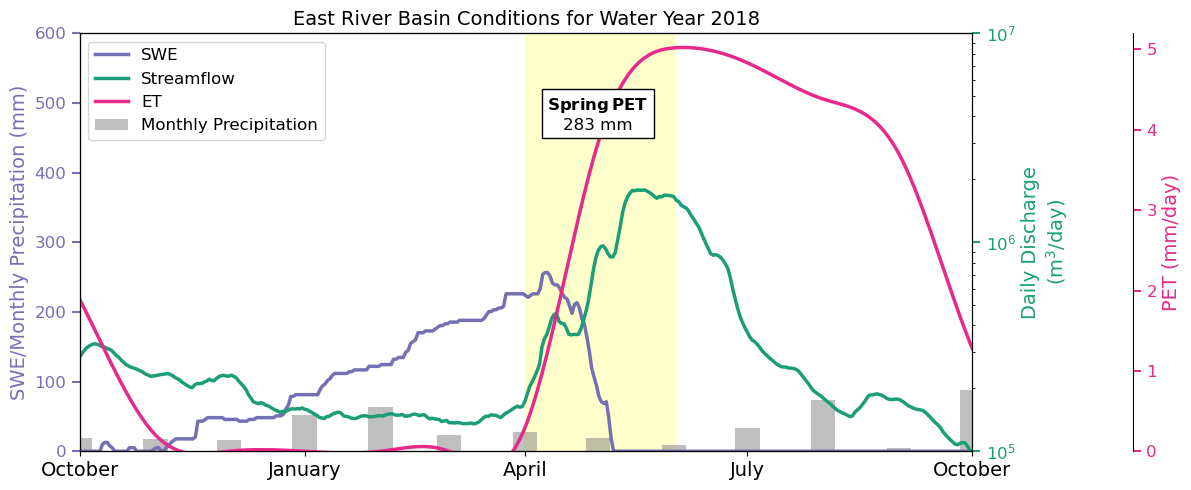

In [53]:
import pytz
fig, ax = plt.subplots(nrows=1,figsize=(12,5), tight_layout=True)
idx_mask = (east_river_discharge_almont_dv.index>dt.date(2014,10,1)) & (east_river_discharge_almont_dv.index<dt.date(2021,10,17))
colors=['#1b9e77',
        '#d95f02',
        '#7570b3',
        '#e7298a']
labels = ['Oct 2015', 'Oct 2016','Oct 2017','Oct 2018','Oct 2019','Oct 2020','Oct 2021']
locs = [dt.date(2015,10,1),dt.date(2016,10,1),dt.date(2017,10,1),dt.date(2018,10,1),dt.date(2019,10,1),dt.date(2020,10,1),dt.date(2021,10,1)]
non_snow_precip = non_snow_precip.groupby(pd.Grouper(freq='W')).sum()*2.54

tkw = dict(size=6, width=1.5, labelsize=12)
# Plot discharge
ax.plot(pd.to_datetime(butte_sntl[butte_sntl['water_year'].isin([2018])].index),
        butte_sntl[butte_sntl['water_year'].isin([2018])]['SWE']*25.4, 
        color=colors[2],
        lw=2.5, 
        alpha=1.0,
        label='SWE')
ax.set_ylabel('SWE/Monthly Precipitation (mm)', color=colors[2], size=14)

ax.tick_params(axis='y', colors=colors[2], **tkw)
ax.set_ylim(0,600)
# add bar plot with monthly precip
ax.bar(pd.to_datetime(ppt_ds_monthly.time), ppt_ds_monthly.values, color='grey', alpha=0.5, width=10, label='Monthly Precipitation')


# Plot streamflow
ax2 = ax.twinx()
ax2.plot(east_river_discharge_almont_dv[idx_mask].index, 
        (east_river_discharge_almont_dv[idx_mask]*0.0283168*3600*24).rolling(7).mean(), # /760e3
        color=colors[0],
        lw=2.5, 
        alpha=1.0)
ax2.set_yscale('log')
ax2.set_ylabel('Daily Discharge\n(m$^3$/day)', color=colors[0], size=14)
ax2.tick_params(axis='y', colors=colors[0], **tkw)
ax.plot([],[],color=colors[0], alpha=1.0, label='Streamflow',lw=2.5,)
ax2.set_ylim(10e4,10e6)

# Plot ET
ax3 = ax.twinx()
ax3.plot(pet_ds_2017.time,
        pet_ds_2017.values/31, 
        color=colors[3],
        lw=2.5, 
        alpha=1.0)
ax3.set_ylabel('PET (mm/day)', color=colors[3], size=14)
ax3.spines.right.set_position(("axes", 1.18))
ax3.tick_params(axis='y', colors=colors[3], **tkw)
ax3.set_ylim(0,5.2)
ax.plot([],[],color=colors[3], alpha=1.0, label='ET',lw=2.5,)

# Plot DTW
# ax4 = ax.twinx()
# ax4.plot(pd.to_datetime(er_dtw_daily_df_filtered.index), 
#         -er_dtw_daily_df_filtered.mean(axis=1).interpolate().rolling(7).mean(), 
#         label='DTW',
#         lw=2.5,
#         color=colors[1])
# ax4.set_ylabel('Depth to Water\n(m-bgs)', color=colors[1], size=14)
# ax4.spines.right.set_position(("axes", 1.3))
# ax4.tick_params(axis='y', colors=colors[1], **tkw)
# ax4.set_ylim(0,-er_dtw_daily_df_filtered[cols[1]].max())
# ax4.invert_yaxis()
# ax.plot([],[],color=colors[1], alpha=1.0, label='Depth to Water',lw=2.5,)


# ax.set_title('East River Basin, CO')
ax.set_xlim(dt.date(2017,10,1),dt.date(2018,10,1))
ax.set_xticks([dt.date(2017,10,1),dt.date(2018,1,1),dt.date(2018,4,1),dt.date(2018,7,1),dt.date(2018,10,1)])
# add an axvspan for months 4 to 6
ax.axvspan(dt.date(2018,4,1), dt.date(2018,6,1), alpha=0.2, color='yellow',zorder=0)
# add a white text box with the sum of spring pet
ax3.text(dt.date(2018,5,1), 4, r"$\bf{Spring\,PET}$"+f"\n{int(pet_ds_monthly.sel(time=slice(dt.date(2018,4,1),dt.date(2018,6,30))).sum().values, )} mm",
        bbox=dict(facecolor='white', alpha=1),zorder=100, size=12, horizontalalignment='center')        
ax.set_xticklabels(['October', 'January','April','July','October'], size=14)
ax.legend(ncol=1, loc='upper left', fontsize=12)
ax.set_title('East River Basin Conditions for Water Year 2018', size=14)

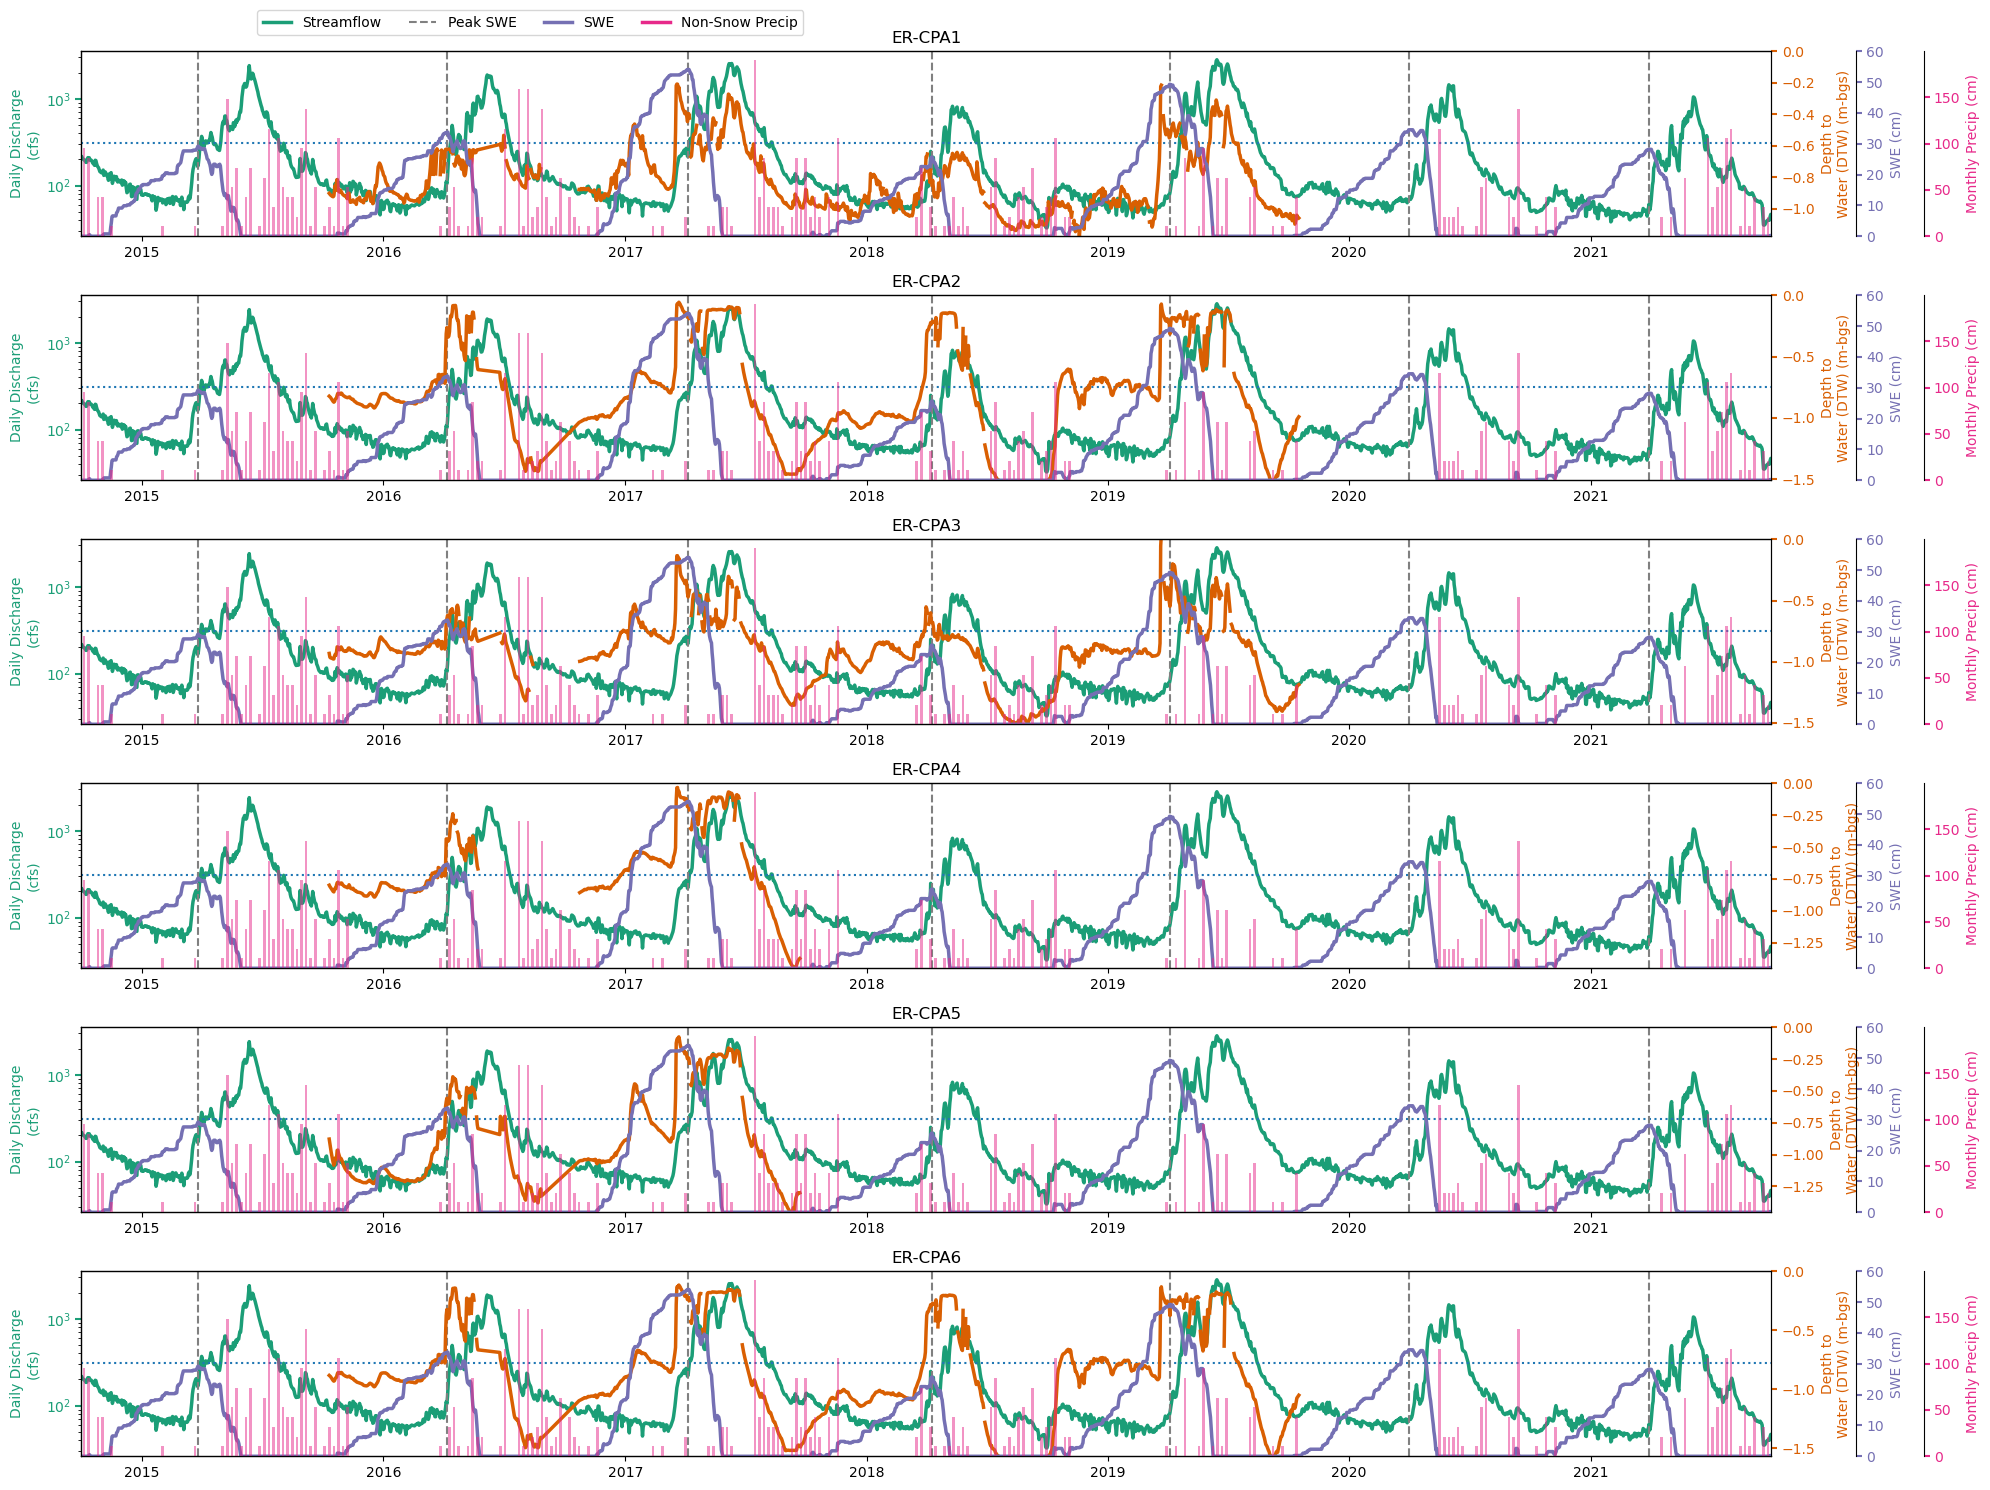

In [ ]:
import pytz
fig, axs = plt.subplots(nrows=6,figsize=(20,15), tight_layout=True)
idx_mask = (east_river_discharge_almont_dv.index>dt.date(2014,10,1)) & (east_river_discharge_almont_dv.index<dt.date(2021,10,17))
colors=['#1b9e77',
        '#d95f02',
        '#7570b3',
        '#e7298a']
labels = ['Oct 2015', 'Oct 2016','Oct 2017','Oct 2018','Oct 2019','Oct 2020','Oct 2021']
locs = [dt.date(2015,10,1),dt.date(2016,10,1),dt.date(2017,10,1),dt.date(2018,10,1),dt.date(2019,10,1),dt.date(2020,10,1),dt.date(2021,10,1)]
non_snow_precip = non_snow_precip.groupby(pd.Grouper(freq='W')).sum()*2.54

for i,ax in enumerate(axs):

    tkw = dict(size=4, width=1.5)
    # Plot discharge
    ax.plot(east_river_discharge_almont_dv[idx_mask].index, 
            east_river_discharge_almont_dv[idx_mask], 
            color=colors[0],
            lw=2.5, 
            alpha=1.0)
    ax.set_yscale('log')
    ax.set_ylabel('Daily Discharge\n(cfs)', color=colors[0])
#     ax.set_xticks(locs)
    ax.tick_params(axis='y', colors=colors[0], **tkw)
    ax.axhline(east_river_discharge_almont_dv.mean(), ls='dotted')
    ax.plot([],[],color=colors[0], alpha=1.0, label='Streamflow',lw=2.5,)
    for j,date in enumerate(max_swe_dates):
        if j == 0:
            ax.axvline(date, color='grey', ls='--', label= 'Peak SWE', alpha=1)
        else:
            ax.axvline(date, color='grey', ls='--', alpha=1)

    # Plot depth to water
    ax2 = ax.twinx()
    ax2.plot(pd.to_datetime(er_dtw_daily_df_filtered.index), 
            -er_dtw_daily_df_filtered[cols[i]], 
            label='DTW',
            lw=2.5,
            color=colors[1])
    ax2.set_ylabel('Depth to\nWater (DTW) (m-bgs)', color=colors[1])
    ax2.tick_params(axis='y', colors=colors[1], **tkw)
    ax.set_title(cols[i])
    ax2.set_ylim(0,-er_dtw_daily_df_filtered[cols[i]].max())
    ax2.invert_yaxis()
    
    # Plot SWE
    ax3 = ax.twinx()
    ax3.plot(pd.to_datetime(butte_sntl[butte_sntl['water_year'].isin([2015,2016,2017,2018,2019,2020,2021])].index),
            butte_sntl[butte_sntl['water_year'].isin([2015,2016,2017,2018,2019,2020,2021])]['SWE']*2.54, 
            color=colors[2],
            lw=2.5, 
            alpha=1.0)
    ax3.set_ylabel('SWE (cm)', color=colors[2])
    ax3.spines.right.set_position(("axes", 1.05))
    ax3.tick_params(axis='y', colors=colors[2], **tkw)
    ax3.set_ylim(0,60)
    ax.plot([],[],color=colors[2], alpha=1.0, label='SWE',lw=2.5,)

    # Plot precip
    ax4 = ax.twinx()
    ax4.bar(non_snow_precip.loc[dt.datetime(2014,10,1, tzinfo=pytz.UTC):dt.datetime(2021,10,1, tzinfo=pytz.UTC)].dropna().index,
        non_snow_precip.loc[dt.datetime(2014,10,1, tzinfo=pytz.UTC):dt.datetime(2021,10,1, tzinfo=pytz.UTC)].dropna(), 
        width=4,
        color=colors[3], 
        alpha=0.5)
    ax4.set_ylabel('Monthly Precip (cm)', color=colors[3])
    ax4.spines.right.set_position(("axes", 1.09))
    ax4.tick_params(axis='y', colors=colors[3], **tkw)
    # ax4.set_ylim(0,30)
    ax.plot([],[],color=colors[3], alpha=1.0, label='Non-Snow Precip', lw=2.5,)
    
    ax.set_xlim(dt.date(2014,10,1),dt.date(2021,10,1))
axs[0].legend(ncol=4, bbox_to_anchor=(0.10,1.05))
fig.savefig('Q_dtw_swe_P.png', facecolor='white')

Influence of early season snowfall on streamflow is minimal, this does rebound GW levels but not always. 2015 was a whacky year, we had a ton of summer precipitation and a pretty normal snow year so it looks like the peak discharge was significantly offset to a later time period. Definitely an odd occurance.

### Simple model of ET 
$ET = P - Q$

Next we want to start thinking about Budyko Curves and start looking into baseflow conditions

## Taylor Park Met Data 1988-2021

In [ ]:
# Get data and filter appropriately
taylor_park_elev = 3201

# Calculated lw net and winterize the data
winter_taylor_park_df = taylor_park_df.loc[(taylor_park_df.index.month < 4) | (taylor_park_df.index.month == 12) ]
net_taylor_winter = calc_net_lw_radiation(temperature=winter_taylor_park_df['AveT'], 
                      relative_humidity=winter_taylor_park_df['AveRH'],
                      elevation=taylor_park_elev
                        )


In [ ]:
winter_taylor_park_dfs= []
non_winter_taylor_park_dfs=[]
# taylor_park_df.loc[(taylor_park_df.index.date < max_swe_dates[1991]) | (taylor_park_df.index.month == 12) ]
for year in max_swe_dates.index:
    tmp = taylor_park_df[taylor_park_df['Water_Yr']==year]
    tmp_df = tmp.loc[(tmp.index.date < max_swe_dates[year].date()) | (tmp.index.month == 12) ]
    winter_taylor_park_dfs.append(tmp_df)
    tmp_df = tmp.loc[(tmp.index.date > max_swe_dates[year].date()) | (tmp.index.month != 12) ]
    non_winter_taylor_park_dfs.append(tmp_df)

In [ ]:
winter_taylor_park_df = pd.concat(winter_taylor_park_dfs)
non_winter_taylor_park_df = pd.concat(non_winter_taylor_park_dfs)

In [ ]:
import xarray as xr
sebs_ds = xr.open_dataset('../SAIL_notebooks/sebs_ds.nc')

rnet_daily = sebs_ds.net_radiation.resample(time='1D').mean()
narr_rad = xr.open_dataset('./data/met/NARR_rnet_1980_2022.nc')
narr_radnet = narr_rad.dswrf - narr_rad.uswrf + narr_rad.dlwrf - narr_rad.ulwrf
narr_radnet_mean = narr_radnet.mean(dim='x').mean(dim='y')
# narr_radnet_mean_winter = narr_radnet_mean.where((narr_radnet_mean['time.month'] < 5) | (narr_radnet_mean['time.month'] > 11) & (narr_radnet_mean['time.month'] > 11))
narr_radnet_mean_winter = narr_radnet_mean.sel(time=winter_taylor_park_df.index, method='nearest') + rnet_daily.median()


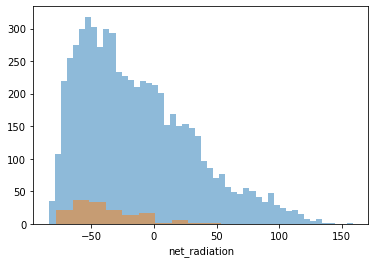

In [ ]:
# net_taylor_winter.plot.hist(bins=50, alpha=0.5);
(narr_radnet_mean_winter).plot.hist(bins=50, alpha=0.5);
rnet_daily.plot.hist(bins=10, alpha=0.5);

In [ ]:
# Years in highest and lowest quartile of temperature:
taylor_park_annual_df = taylor_park_df[(taylor_park_df['Water_Yr']>1988) &(taylor_park_df['Water_Yr']<2022)].groupby(['Water_Yr']).mean()

warm_years = taylor_park_annual_df[taylor_park_annual_df['AveT']>np.percentile(taylor_park_annual_df['AveT'],75)].index
cold_years = taylor_park_annual_df[taylor_park_annual_df['AveT']<np.percentile(taylor_park_annual_df['AveT'],25)].index

In [ ]:
lat = 38 * np.pi / 180  
nn = pyet.daylight_hours(winter_taylor_park_df.index, lat)
rs_in = pyet.calc_rad_sol_in(winter_taylor_park_df.index, lat, nn)
rs_in = pd.Series(rs_in, index=winter_taylor_park_df.index)
rnl = pyet.calc_rad_long(rs_in, winter_taylor_park_df['AveT'], tmin=winter_taylor_park_df['MinT'], tmax=winter_taylor_park_df['MaxT'],
                         rhmax=winter_taylor_park_df['MaxRH'], rhmin=winter_taylor_park_df['MinRH'], lat=lat, elevation=taylor_park_elev)
rns = pyet.calc_rad_short(rs_in, albedo=0.8)

rnet = rns - rnl

sublimation_taylor_pm = pyet.pm(tmean=winter_taylor_park_df['AveT'],
        tmax=winter_taylor_park_df['MaxT'],
        tmin=winter_taylor_park_df['MinT'],
        rhmax=winter_taylor_park_df['MaxRH'],
        rhmin=winter_taylor_park_df['MinRH'],
        wind=winter_taylor_park_df['WSpd'],
        rh=winter_taylor_park_df['AveRH'],
        rn=rnet,
        elevation=taylor_park_elev,
        r_l=0,
        r_s=0,
        ra_method=1)
sublimation_taylor_pm_df = sublimation_taylor_pm.to_frame(name='sublimation_mm')
sublimation_taylor_pm_df['water_year'] =  sublimation_taylor_pm_df.index.year.where(sublimation_taylor_pm_df.index.month < 10, sublimation_taylor_pm_df.index.year + 1)
sublimation_taylor_totals = sublimation_taylor_pm_df['sublimation_mm'].groupby(sublimation_taylor_pm_df['water_year']).sum()
sublimation_taylor_totals.rename = 'sublimation'  
      

TypeError: <class 'datetime.time'> is not convertible to datetime

In [ ]:
sublimation_taylor_pm = pyet.pm(tmean=winter_taylor_park_df['AveT'],
        tmax=winter_taylor_park_df['MaxT'],
        tmin=winter_taylor_park_df['MinT'],
        rhmax=winter_taylor_park_df['MaxRH'],
        rhmin=winter_taylor_park_df['MinRH'],
        wind=winter_taylor_park_df['WSpd'],
        rh=winter_taylor_park_df['AveRH'],
        rn=narr_radnet_mean_winter.values*3600*24/1e6 ,
        elevation=taylor_park_elev,
        r_l=0,
        r_s=0,
        ra_method=1)
sublimation_taylor_pm_df = sublimation_taylor_pm.to_frame(name='sublimation_mm')
sublimation_taylor_pm_df['water_year'] =  sublimation_taylor_pm_df.index.year.where(sublimation_taylor_pm_df.index.month < 10, sublimation_taylor_pm_df.index.year + 1)
sublimation_taylor_totals_narr = sublimation_taylor_pm_df['sublimation_mm'].groupby(sublimation_taylor_pm_df['water_year']).sum()
sublimation_taylor_totals_narr.rename = 'sublimation'  
      

In [ ]:
# lat = 38 * np.pi / 180  
# nn = pyet.daylight_hours(non_winter_taylor_park_df.index, lat)
# rs_in = pyet.calc_rad_sol_in(non_winter_taylor_park_df.index, lat, nn)
# rs_in = pd.Series(rs_in, index=non_winter_taylor_park_df.index)
# rnl = pyet.calc_rad_long(rs_in, non_winter_taylor_park_df['AveT'], tmin=non_winter_taylor_park_df['MinT'], tmax=non_winter_taylor_park_df['MaxT'],
#                          rhmax=non_winter_taylor_park_df['MaxRH'], rhmin=non_winter_taylor_park_df['MinRH'], lat=lat, elevation=taylor_park_elev)
# rns = pyet.calc_rad_short(rs_in, albedo=0.25)

# rnet = rns - rnl

# pet_taylor_pm = pyet.pm(tmean=non_winter_taylor_park_df['AveT'],
#         tmax=non_winter_taylor_park_df['MaxT'],
#         tmin=non_winter_taylor_park_df['MinT'],
#         rhmax=non_winter_taylor_park_df['MaxRH'],
#         rhmin=non_winter_taylor_park_df['MinRH'],
#         wind=non_winter_taylor_park_df['WSpd'],
#         rh=non_winter_taylor_park_df['AveRH'],
#         rn=rnet,
#         elevation=taylor_park_elev,
#         ra_method=1,
#         r_l=400,
#         r_s=500,)
# pet_taylor_pm_df = pet_taylor_pm.to_frame(name='pet_mm')
# pet_taylor_pm_df['water_year'] =  pet_taylor_pm_df.index.year.where(pet_taylor_pm_df.index.month < 10, pet_taylor_pm_df.index.year + 1)
# pet_taylor_totals = pet_taylor_pm_df['pet_mm'].groupby(pet_taylor_pm_df['water_year']).sum()
# pet_taylor_totals.rename = 'pet'  

Butte and East River Relationship

In [19]:

east_annual_post1992_norm = (east_river_discharge_almont_post_1992['mean_discharge'] - east_river_discharge_almont_post_1992['mean_discharge'].mean())/east_river_discharge_almont_post_1992['mean_discharge'].std()

In [20]:
slope, intercept, rvalue, pvalue, stderr = stats.linregress(butte_sntl_peaks_post1992_norm.loc[1992:], east_annual_post1992_norm)

alpha = 0.05
c = (1 - alpha)

# Create regression line and residuals
X = butte_sntl_peaks_post1992_norm
y_predicted = intercept + slope*X
residual = (east_annual_post1992_norm-y_predicted)

# Setup 
n = X.size                                               
dof = n - 2
t = stats.t.ppf(c, dof) 

# sum of squared errors
sse = np.sum(residual**2)

# total sum of squares (y)
sst = np.sum( (east_annual_post1992_norm - np.mean(east_annual_post1992_norm))**2 )

# total sum of squares (x)
sst_x = np.sum( (X - np.mean(X))**2 )

# correlation coefficient
r_squared = 1 - sse/sst

# standard error of regression
s = np.sqrt(sse/(n-2))

# an array of x values
p_x = np.linspace(X.min(),X.max(),100)

# using our model parameters to predict y values
p_y = intercept + slope*p_x

# compute error of prediction for each p_x
sigma_ep = np.sqrt( s**2 * (1+ 1/n + ( ( n*(p_x-X.mean())**2 ) / ( n*np.sum(X**2) - np.sum(X)**2 ) ) ) )
# set our confidence interval

p_y_lower = p_y - t * sigma_ep
p_y_upper = p_y + t * sigma_ep


In [59]:
butte_sntl['water_year'] = butte_sntl.index.year.where(butte_sntl.index.month < 9, butte_sntl.index.year + 1)

In [68]:
fall_precip = butte_sntl.loc[(butte_sntl.index.month.isin([9,10,11]))]
fall_precip_norm_anomaly = normalize_data(fall_precip['PRECIPITATON'].groupby(fall_precip['water_year']).sum())

spring_precip = butte_sntl.loc[(butte_sntl.index.month.isin([3,4,5]))]
spring_precip_norm_anomaly = normalize_data(spring_precip['PRECIPITATON'].groupby(spring_precip['water_year']).sum())
spring_precip_norm_anomaly = spring_precip_norm_anomaly.drop(1991)

In [41]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18
plt.style.use('ggplot')
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

(-3.5, 3.5)

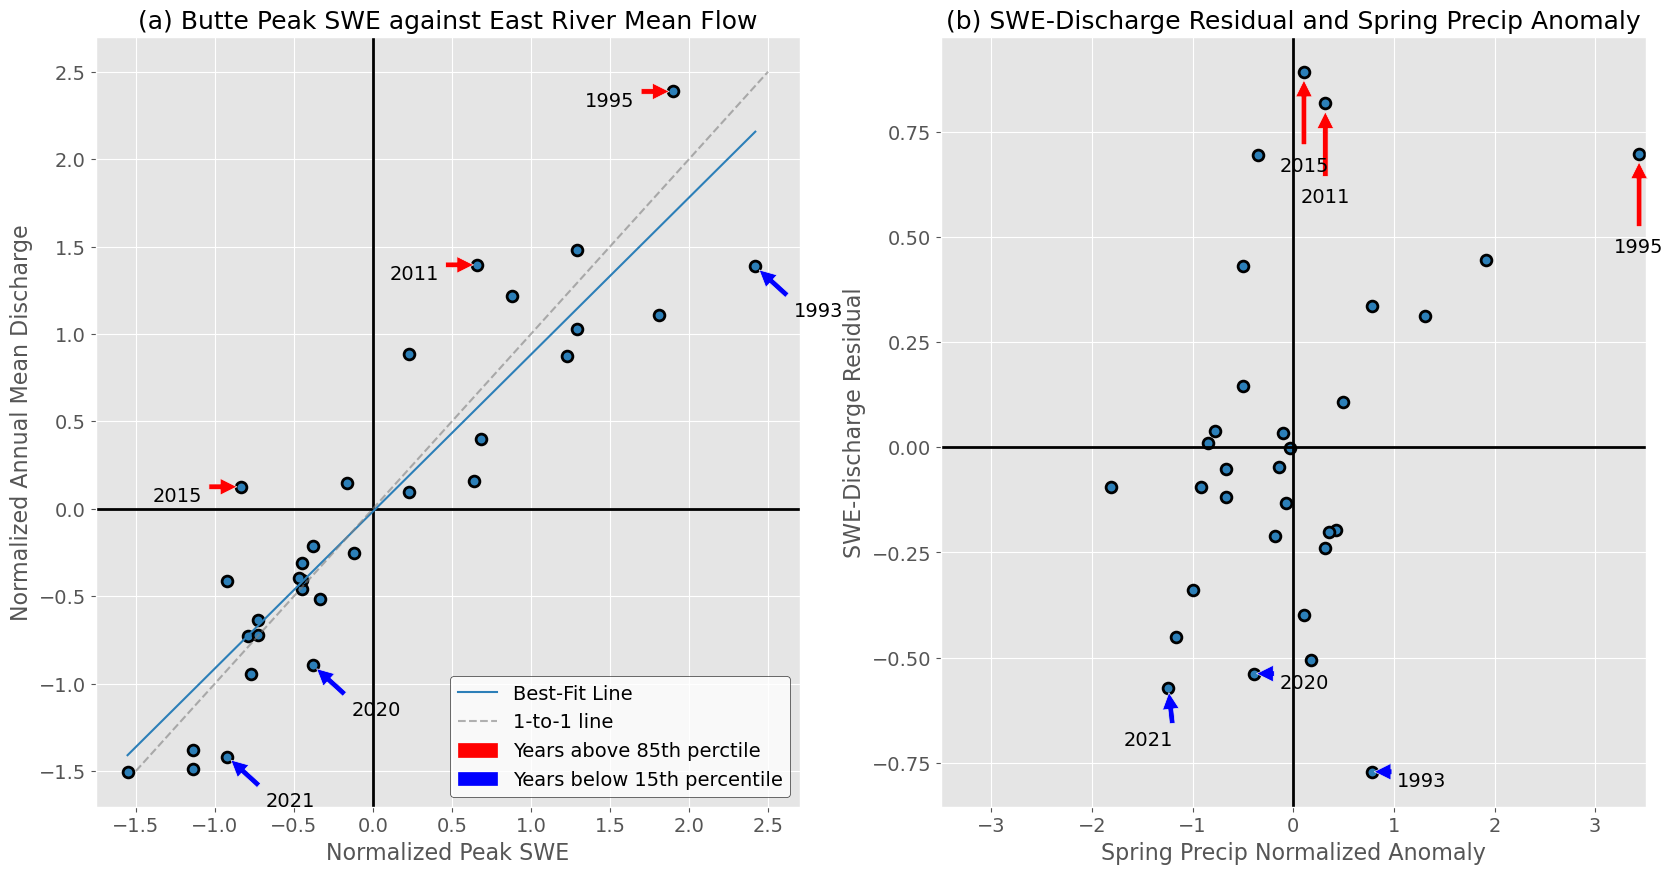

In [72]:
fig, axs = plt.subplots(ncols=2, figsize=(20,10))
colors = ['#2c7fb8','#7fcdbb']
residual=residual.dropna()
idx_25th_percentile = (residual[residual < np.percentile(residual,10)].index)
idx_95th_percentile = residual[residual > np.percentile(residual,90)].index


axs[0].scatter(butte_sntl_peaks_post1992_norm.loc[1992:], east_annual_post1992_norm, color=colors[0], edgecolor='k', s=60, lw=2)
axs[0].axhline(0, color='k', lw=2)
axs[0].axvline(0, color='k', lw=2)
axs[0].plot([X.min(),X.max()], intercept+slope*np.array([X.min(),X.max()]), color=colors[0], label='Best-Fit Line')
axs[0].plot([-1.5,2.5],[-1.5,2.5], label='1-to-1 line', color='grey', ls='--', alpha=0.6)
# axs[0].plot(p_x, p_y_lower, color=colors[1], ls='--', label='Upper/Lower 90% Confidence Bound')
# axs[0].plot(p_x, p_y_upper, color=colors[1], ls='--', )
# axs[0].fill_between(p_x, p_y_lower,p_y_upper, color=colors[1], alpha=0.3)

axs[1].scatter(spring_precip_norm_anomaly,residual.loc[1992:],color=colors[0],edgecolor='k', s=60, lw=2);
axs[1].axhline(0, color='k', lw=2)
axs[1].axvline(0, color='k', lw=2)
axs[1].set_xlabel('Spring Precip Normalized Anomaly')
axs[1].set_ylabel('SWE-Discharge Residual',)
axs[1].set_title('(b) SWE-Discharge Residual and Spring Precip Anomaly')


for i,idx in enumerate(idx_25th_percentile):
    if idx in [2012,2017,2018]:
        axs[0].annotate(str(idx), 
                    (butte_sntl_peaks_post1992_norm.loc[idx], east_annual_post1992_norm.loc[idx]),
                    (butte_sntl_peaks_post1992_norm.loc[idx]+0.2, east_annual_post1992_norm.loc[idx]-0.4),
                    arrowprops=dict(facecolor='blue', shrink=0.1),
                    horizontalalignment='center', verticalalignment='top',)
    elif idx in [2021]:
        axs[0].annotate(str(idx), 
                        (butte_sntl_peaks_post1992_norm.loc[idx], east_annual_post1992_norm.loc[idx]),
                        (butte_sntl_peaks_post1992_norm.loc[idx]+0.4, east_annual_post1992_norm.loc[idx]-0.2),
                        arrowprops=dict(facecolor='blue', shrink=0.1),
                        horizontalalignment='center', verticalalignment='top',)
        axs[1].annotate(str(idx), 
                (spring_precip_norm_anomaly.loc[idx], residual.loc[idx]),
                (spring_precip_norm_anomaly.loc[idx]-0.2, residual.loc[idx]-0.1),
                arrowprops=dict(facecolor='blue', shrink=0.1),
                horizontalalignment='center', verticalalignment='top',)
                
    else:
        axs[0].annotate(str(idx), 
                        (butte_sntl_peaks_post1992_norm.loc[idx], east_annual_post1992_norm.loc[idx]),
                        (butte_sntl_peaks_post1992_norm.loc[idx]+0.4, east_annual_post1992_norm.loc[idx]-0.2),
                        arrowprops=dict(facecolor='blue', shrink=0.1),
                        horizontalalignment='center', verticalalignment='top',)
        axs[1].annotate(str(idx), 
                (spring_precip_norm_anomaly.loc[idx], residual.loc[idx]),
                (spring_precip_norm_anomaly.loc[idx]+0.5, residual.loc[idx]),
                arrowprops=dict(facecolor='blue', shrink=0.1),
                horizontalalignment='center', verticalalignment='top',)

for i,idx in enumerate(idx_95th_percentile):
    if idx == 2001:
        axs[0].annotate(str(idx), 
                (butte_sntl_peaks_post1992_norm.loc[idx], east_annual_post1992_norm.loc[idx]),
                (butte_sntl_peaks_post1992_norm.loc[idx], east_annual_post1992_norm.loc[idx]-0.4),
                arrowprops=dict(facecolor='red', shrink=0.1),
                horizontalalignment='center', verticalalignment='top',)
        
    else:
        axs[0].annotate(str(idx), 
                (butte_sntl_peaks_post1992_norm.loc[idx], east_annual_post1992_norm.loc[idx]),
                (butte_sntl_peaks_post1992_norm.loc[idx]-0.4, east_annual_post1992_norm.loc[idx]),
                arrowprops=dict(facecolor='red', shrink=0.1),
                horizontalalignment='center', verticalalignment='top',)
        axs[1].annotate(str(idx), 
                (spring_precip_norm_anomaly.loc[idx], residual.loc[idx]),
                (spring_precip_norm_anomaly.loc[idx], residual.loc[idx]-0.2),
                arrowprops=dict(facecolor='red', shrink=0.1),
                horizontalalignment='center', verticalalignment='top',)

axs[0].arrow([],[],[],[], color='red', label='Years above 85th perctile',width=0.1)
axs[0].arrow([],[],[],[], color='blue', label='Years below 15th percentile',width=0.1)
axs[0].set_xlabel('Normalized Peak SWE')
axs[0].set_ylabel('Normalized Annual Mean Discharge')
axs[0].set_title('(a) Butte Peak SWE against East River Mean Flow')
axs[0].legend(edgecolor='k', facecolor='white')
axs[1].set_xlim(-3.5,3.5)



In [62]:
fall_precip_norm_anomaly

water_year
1992    1.414855
1993   -0.434336
1994    1.125919
1995    1.068132
1996   -0.781060
1997    1.530430
1998    0.605834
1999    0.894770
2000   -1.185571
2001   -0.896634
2002    0.721409
2003    1.010345
2004   -0.318762
2005    0.952557
2006    0.663621
2007    1.646004
2008   -1.069996
2009   -0.723273
2010   -0.781060
2011    0.259111
2012   -0.607698
2013   -1.994592
2014    0.432472
2015    0.605834
2016    0.201323
2017   -0.954422
2018   -1.069996
2019    0.836983
2020   -1.127783
2021   -1.069996
2022   -0.954422
Name: PRECIPITATON, dtype: float64

ValueError: x and y must be the same size

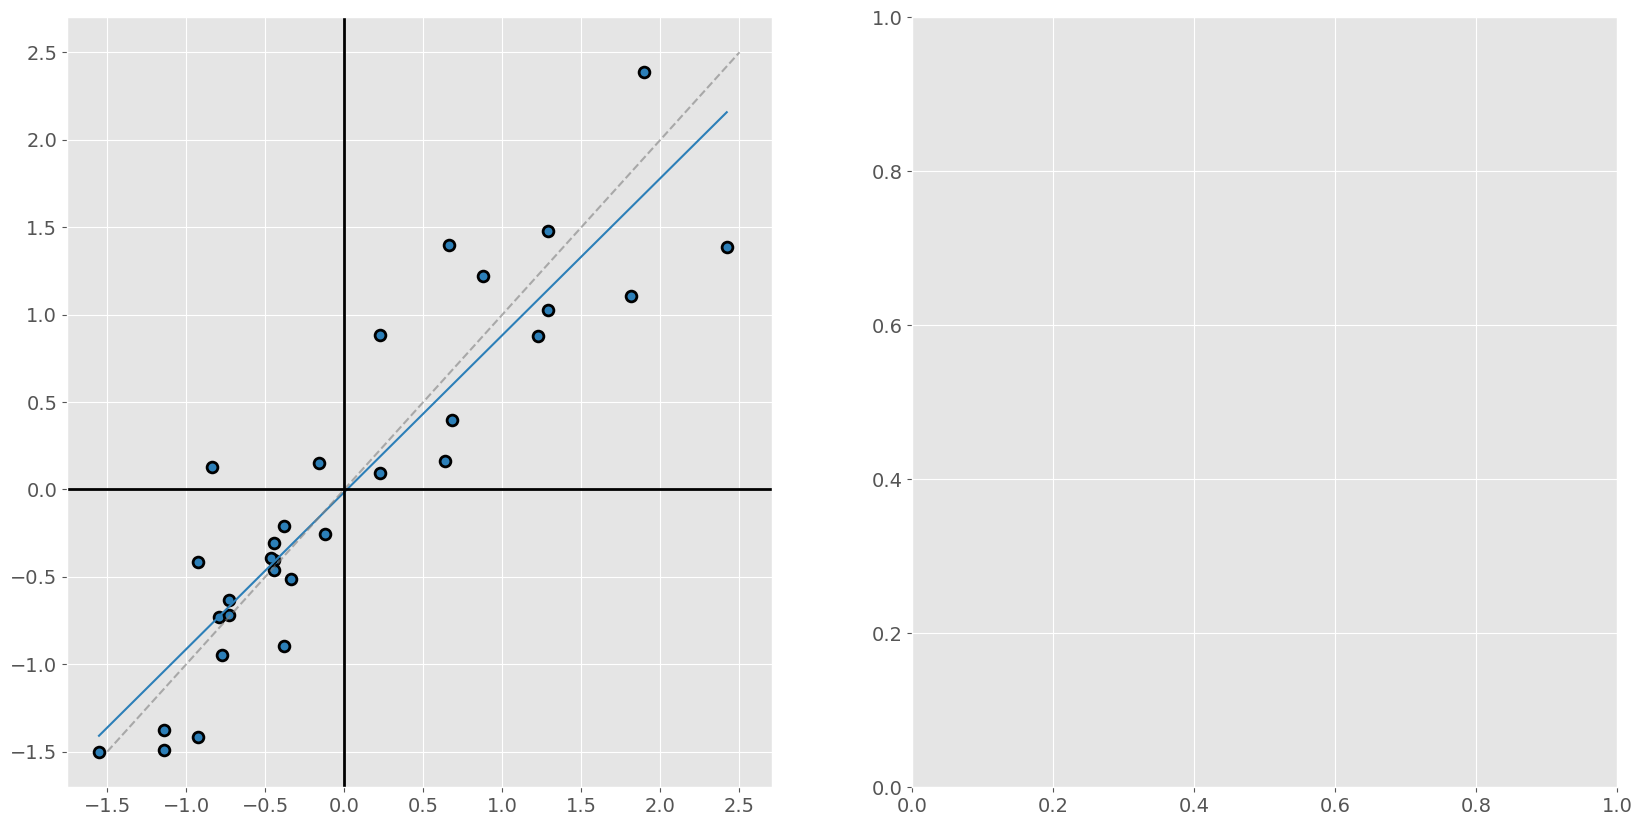

In [65]:
fig, axs = plt.subplots(ncols=2, figsize=(20,10))
colors = ['#2c7fb8','#7fcdbb']
residual=residual.dropna()
idx_25th_percentile = (residual[residual < np.percentile(residual,10)].index)
idx_95th_percentile = residual[residual > np.percentile(residual,90)].index


axs[0].scatter(butte_sntl_peaks_post1992_norm.loc[1992:], east_annual_post1992_norm, color=colors[0], edgecolor='k', s=60, lw=2)
axs[0].plot([X.min(),X.max()], intercept+slope*np.array([X.min(),X.max()]), color=colors[0], label='Best-Fit Line')
axs[0].plot([-1.5,2.5],[-1.5,2.5], label='1-to-1 line', color='grey', ls='--', alpha=0.6)
axs[0].axhline(0, color='k', lw=2)
axs[0].axvline(0, color='k', lw=2)
# axs[0].plot(p_x, p_y_lower, color=colors[1], ls='--', label='Upper/Lower 90% Confidence Bound')
# axs[0].plot(p_x, p_y_upper, color=colors[1], ls='--', )
# axs[0].fill_between(p_x, p_y_lower,p_y_upper, color=colors[1], alpha=0.3)

axs[1].scatter(fall_precip_norm_anomaly,residual.loc[1992:],color=colors[0],edgecolor='k', s=60, lw=2);
axs[1].axhline(0, color='k', lw=2)
axs[1].axvline(0, color='k', lw=2)
axs[1].set_xlabel('OCT + NOV Precip Normalized Anomaly')
axs[1].set_ylabel('SWE-Discharge Residual',)
axs[1].set_title('(b) SWE-Discharge Residual and Oct+Nov Precip Anomaly')


for i,idx in enumerate(idx_25th_percentile):
    if idx in [2012,2017,2018]:
        axs[0].annotate(str(idx), 
                    (butte_sntl_peaks_post1992_norm.loc[idx], east_annual_post1992_norm.loc[idx]),
                    (butte_sntl_peaks_post1992_norm.loc[idx]+0.2, east_annual_post1992_norm.loc[idx]-0.4),
                    arrowprops=dict(facecolor='blue', shrink=0.1),
                    horizontalalignment='center', verticalalignment='top',)
    elif idx in [2020]:
        axs[0].annotate(str(idx), 
                        (butte_sntl_peaks_post1992_norm.loc[idx], east_annual_post1992_norm.loc[idx]),
                        (butte_sntl_peaks_post1992_norm.loc[idx]+0.4, east_annual_post1992_norm.loc[idx]-0.2),
                        arrowprops=dict(facecolor='blue', shrink=0.1),
                        horizontalalignment='center', verticalalignment='top',)
        axs[1].annotate(str(idx), 
                (fall_precip_norm_anomaly.loc[idx], residual.loc[idx]),
                (fall_precip_norm_anomaly.loc[idx]-0.2, residual.loc[idx]-0.1),
                arrowprops=dict(facecolor='blue', shrink=0.1),
                horizontalalignment='center', verticalalignment='top',)
                
    else:
        axs[0].annotate(str(idx), 
                        (butte_sntl_peaks_post1992_norm.loc[idx], east_annual_post1992_norm.loc[idx]),
                        (butte_sntl_peaks_post1992_norm.loc[idx]+0.4, east_annual_post1992_norm.loc[idx]-0.2),
                        arrowprops=dict(facecolor='blue', shrink=0.1),
                        horizontalalignment='center', verticalalignment='top',)
        axs[1].annotate(str(idx), 
                (fall_precip_norm_anomaly.loc[idx], residual.loc[idx]),
                (fall_precip_norm_anomaly.loc[idx]+0.5, residual.loc[idx]),
                arrowprops=dict(facecolor='blue', shrink=0.1),
                horizontalalignment='center', verticalalignment='top',)

for i,idx in enumerate(idx_95th_percentile):
    if idx == 2001:
        axs[0].annotate(str(idx), 
                (butte_sntl_peaks_post1992_norm.loc[idx], east_annual_post1992_norm.loc[idx]),
                (butte_sntl_peaks_post1992_norm.loc[idx], east_annual_post1992_norm.loc[idx]-0.4),
                arrowprops=dict(facecolor='red', shrink=0.1),
                horizontalalignment='center', verticalalignment='top',)
        
    else:
        axs[0].annotate(str(idx), 
                (butte_sntl_peaks_post1992_norm.loc[idx], east_annual_post1992_norm.loc[idx]),
                (butte_sntl_peaks_post1992_norm.loc[idx]-0.4, east_annual_post1992_norm.loc[idx]),
                arrowprops=dict(facecolor='red', shrink=0.1),
                horizontalalignment='center', verticalalignment='top',)
        axs[1].annotate(str(idx), 
                (fall_precip_norm_anomaly.loc[idx], residual.loc[idx]),
                (fall_precip_norm_anomaly.loc[idx], residual.loc[idx]-0.2),
                arrowprops=dict(facecolor='red', shrink=0.1),
                horizontalalignment='center', verticalalignment='top',)

axs[0].arrow([],[],[],[], color='red', label='Years above 85th perctile',width=0.1)
axs[0].arrow([],[],[],[], color='blue', label='Years below 15th percentile',width=0.1)
axs[0].set_xlabel('Normalized Peak SWE')
axs[0].set_ylabel('Normalized Annual Mean Discharge')
axs[0].set_title('(a) Butte Peak SWE against East River Mean Flow')
axs[0].legend(edgecolor='k', facecolor='white')




In [81]:
summer_precip = butte_sntl.loc[butte_sntl.index.month.isin([6,7])]
summer_precip_norm_anomaly = normalize_data(summer_precip['PRECIPITATON'].groupby(summer_precip['water_year']).sum())
summer_precip_norm_anomaly.name = 'summer_pcpn'

fall_precip = butte_sntl.loc[(butte_sntl.index.month.isin([10,11]))]
fall_precip_norm_anomaly = normalize_data(fall_precip['PRECIPITATON'].groupby(fall_precip['water_year']).sum())
fall_precip_norm_anomaly.name = 'fall_pcpn'

sublimation_anomaly = normalize_data(sublimation_taylor_totals_narr)
pet_anomaly = normalize_data(pet_taylor_totals)

winter_precip = butte_sntl.loc[butte_sntl.index.month.isin([12,1,2])]
winter_precip_anomaly =  normalize_data(winter_precip['PRECIPITATON'].groupby(winter_precip['water_year']).sum())

spring_precip = butte_sntl.loc[butte_sntl.index.month.isin([4,5])]
spring_precip_anomaly =  normalize_data(spring_precip['PRECIPITATON'].groupby(spring_precip['water_year']).sum())

temperature_anomaly = normalize_data(taylor_park_df['AveT'].groupby(taylor_park_df['Water_Yr']).sum().drop([1988,1989,1990,2022]))
# Park Cone Snow Fraction
park_cone_annual_snow_fraction = park_cone_sntl.groupby('water_year')['SWE'].max()/park_cone_sntl.groupby('water_year')['ACCUMULATED PRECIPITATION'].max()


rh_anomaly = normalize_data(taylor_park_df['MinRH'].groupby(taylor_park_df['Water_Yr']).sum().drop([1988,1989,1990,2022]))
mean_rh = taylor_park_df['AveRH']
mean_rh_anomaly = normalize_data(mean_rh.groupby(mean_rh.index.year).sum().drop([1987,1988,1989,1990,2022]))

residual_anomaly = normalize_data(residual)

NameError: name 'sublimation_taylor_totals_narr' is not defined

Text(0.5, 1.0, 'Correlation Matrix of Different Meteorological Variables\nand SWE-Discharge Residual')

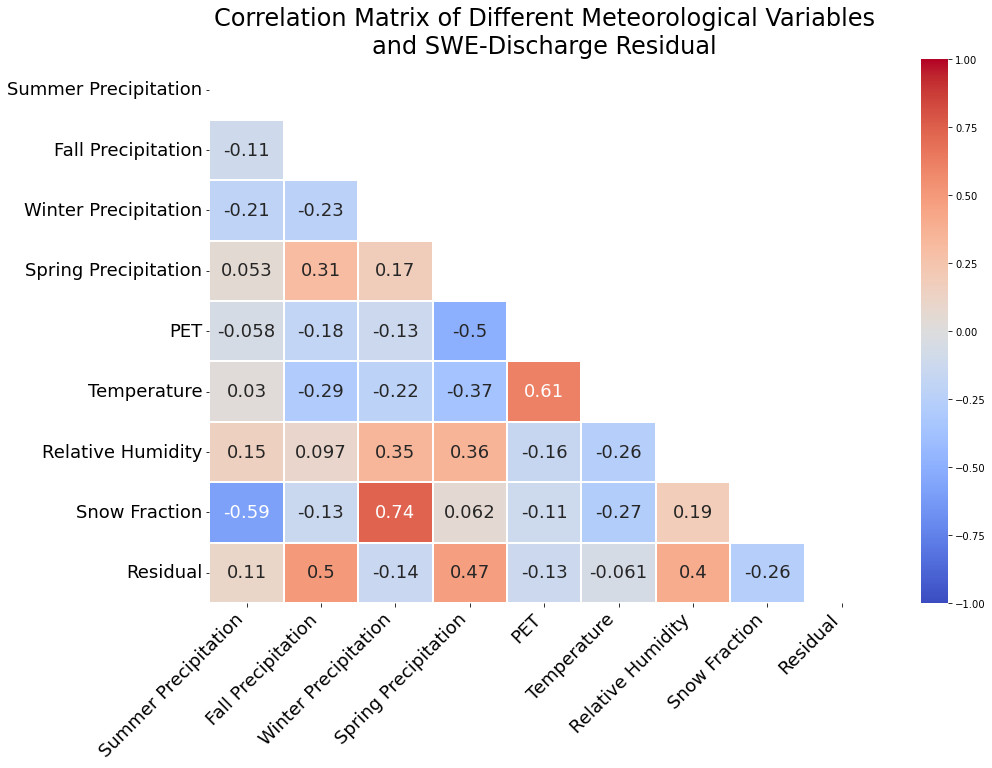

In [874]:
import seaborn as sns
import matplotlib.patches as patches
column_renames = ['Summer Precipitation', 'Fall Precipitation', 'Winter Precipitation', 'Spring Precipitation', 'PET', 'Temperature', 'Relative Humidity','Snow Fraction' 'Residual']
df = pd.concat([summer_precip_norm_anomaly,
            fall_precip_norm_anomaly,
            winter_precip_anomaly,
            spring_precip_anomaly,
            pet_taylor_totals,
            temperature_anomaly,
            mean_rh_anomaly,
            snow_frac_butte,
            residual
            ], axis=1)
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(df.rename(columns=dict(zip(df.columns,column_renames))).corr(), 
            cmap='coolwarm', 
            vmin=-1, vmax=1, 
            mask=mask,
            annot=True,
            annot_kws={'size':18}, 
            linewidths=2,
            ax=ax)
column_renames = ['Summer Precipitation', 'Fall Precipitation', 'Winter Precipitation', 'Spring Precipitation', 'PET', 'Temperature', 'Relative Humidity', 'Snow Fraction','Residual']               
ax.set_xticklabels(column_renames, rotation=45, ha='right', size=18)
# ax.annotate('Correlation Coefficient', xy=(6,3), xytext=(0.93,0.54), xycoords='figure fraction', rotation=90, size=18)

# ax.annotate('Discharge-SWE\nResidual', xy=(6,3), xytext=(0.04,0.26), xycoords='figure fraction', size=17, weight='bold')
# ax.annotate('Discharge-SWE\nResidual', xy=(6,3), xytext=(0.64,0.02), xycoords='figure fraction', size=17, weight='bold', rotation=45)
ax.set_yticklabels(column_renames, size=18)
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

# p1 = patches.Rectangle((0.1,4.1),4.8,0.8, ec='k', fc=None, fill=False, lw=3)
# p2 = patches.Rectangle((4.1,0.1),0.8,4.8, ec='k', fc=None, fill=False, lw=3)
# ax.add_patch(p1)
# ax.add_patch(p2)
# ax.grid()
ax.set_title('Correlation Matrix of Different Meteorological Variables\nand SWE-Discharge Residual', size=24)

In [1052]:
pet_timeseries = pd.concat([sublimation_taylor_pm, pet_taylor_pm])
pet_timeseries.name='pet'
wy = pet_timeseries.index.year.where(pet_timeseries.index.month < 10, pet_timeseries.index.year + 1).values
wy = pd.Series(wy,pet_timeseries.index, name='water_year')
pet_timeseries = pd.concat([pet_timeseries,wy], axis=1)


In [85]:
monthly_mean_temps_schofield[monthly_mean_temps_schofield.water_year==2022]['AIR TEMP']

datetime
2021-10-31 00:00:00+00:00    35.048387
2021-11-30 00:00:00+00:00    31.514000
2021-12-31 00:00:00+00:00    23.156774
2022-01-31 00:00:00+00:00    19.777419
2022-02-28 00:00:00+00:00    17.574286
2022-03-31 00:00:00+00:00    23.958065
2022-04-30 00:00:00+00:00    30.842000
2022-05-31 00:00:00+00:00    39.606452
2022-06-30 00:00:00+00:00    48.026000
2022-07-31 00:00:00+00:00    51.649032
2022-08-31 00:00:00+00:00    50.963871
2022-09-30 00:00:00+00:00    48.998000
Freq: M, Name: AIR TEMP, dtype: float64

In [91]:
monthly_mean_temps_schofield = butte_sntl[['water_year','AIR TEMP']].groupby(pd.Grouper(freq='M')).mean()
monthly_mean_temps_clim_schofield = butte_sntl['AIR TEMP'].groupby(butte_sntl.index.month).mean()

monthly_mean_precip_narr = df_mean[['WY','apcp']].groupby(pd.Grouper(freq='M')).mean()
monthly_mean_precip_clim_narr = df_mean['apcp'].groupby(df_mean.index.month).mean()

# monthly_mean_pet = pet_timeseries[['water_year','pet']].groupby(pd.Grouper(freq='M')).mean()
# monthly_mean_pet_clim = pet_timeseries['pet'].groupby(pet_timeseries.index.month).mean()

monthly_mean_rh = taylor_park_df[['Water_Yr','AveRH']].groupby(pd.Grouper(freq='M')).mean()
monthly_mean_rh_clim = taylor_park_df['AveRH'].groupby(taylor_park_df.index.month).mean()

temp_anomalies = []
precip_anomalies = []
pet_anomalies = []
rh_anomalies = []
idx = np.array([10,11,12,1,2,3,4,5,6,7,8,9])
for year in monthly_mean_temps_schofield.water_year.unique()[:-1]:
    l = len(monthly_mean_temps_schofield[monthly_mean_temps_schofield.index.year==year])
    if year == 1991:
        tmp = monthly_mean_temps_schofield[monthly_mean_temps_schofield.water_year==year]['AIR TEMP'] - monthly_mean_temps_clim_schofield.values[:-3]
   
    else:
        tmp = monthly_mean_temps_schofield[monthly_mean_temps_schofield.water_year==year]['AIR TEMP'] - monthly_mean_temps_clim_schofield.loc[idx].values
    normalized_tmp = tmp/tmp.std()
    temp_anomalies.append(normalized_tmp)

    # Precip anomalies
    tmp = monthly_mean_precip_narr[monthly_mean_precip_narr.WY==year]['apcp'] - monthly_mean_precip_clim_narr.loc[idx].values
    normalized_tmp = tmp/tmp.std()
    precip_anomalies.append(normalized_tmp)

    # PET anomalies
    # tmp = monthly_mean_pet[monthly_mean_pet.water_year==year]['pet'] - monthly_mean_pet_clim.loc[idx].values
    # normalized_tmp = tmp/tmp.std()
    # pet_anomalies.append(normalized_tmp)

    # RH anomalies
    # tmp = monthly_mean_rh[monthly_mean_rh.Water_Yr==year]['AveRH'] - monthly_mean_rh_clim.loc[idx].values
    # normalized_tmp = tmp/tmp.std()
    # rh_anomalies.append(normalized_tmp)





In [739]:
temp_anomalies = pd.concat(temp_anomalies)
temp_anomalies.index = temp_anomalies.index.date
temp_anomalies.name = 'temp'

pet_anomalies = pd.concat(pet_anomalies)
pet_anomalies.index = pet_anomalies.index.date
pet_anomalies.name = 'pet'

precip_anomalies = pd.concat(precip_anomalies)
precip_anomalies.index = precip_anomalies.index.date
precip_anomalies.name = 'precip'

rh_anomalies = pd.concat(rh_anomalies)
rh_anomalies.index = rh_anomalies.index.date
rh_anomalies.name = 'rh'

In [740]:
combined_anomalies = pd.concat([temp_anomalies, pet_anomalies, precip_anomalies, rh_anomalies],axis=1).sort_index()
combined_anomalies.index = pd.to_datetime(combined_anomalies.index)
combined_anomalies['wy'] = combined_anomalies.index.year.where(combined_anomalies.index.month < 10, combined_anomalies.index.year + 1).values

tmp = []
for year in wy.unique():
    a = combined_anomalies[combined_anomalies['wy'] == year]['rh']
    a = a.groupby(a.index.month).mean()
    a = a[idx]
    a.name=year
    tmp.append(a)
combined_anomaly_df = pd.concat(tmp, axis=1).T


Text(0.5, 1.0, 'Temperature Normalized Anomaly (Butte Snotel)')

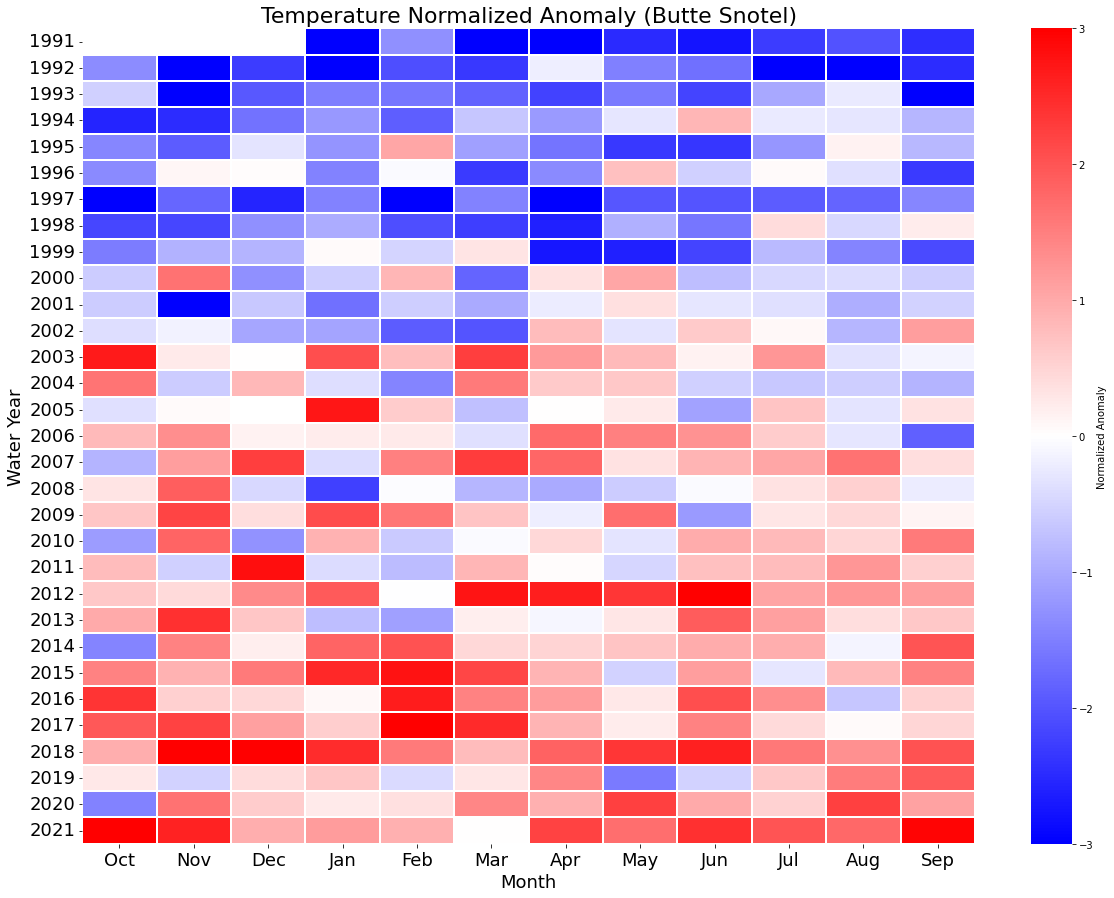

In [730]:
fig, ax=plt.subplots(figsize=(20,15), facecolor='w')

months = ['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep']
sns.heatmap(combined_anomaly_df, cmap='bwr', vmin=-3, vmax=3,linewidths=2, cbar_kws={'label':'Normalized Anomaly'})
ax.set_yticklabels(combined_anomaly_df.index, rotation=0, ha='right', size=18);
ax.set_xticklabels(months, rotation=0, ha='center', size=18);
ax.set_xlabel('Month',size=18)
ax.set_ylabel('Water Year', size=18)
ax.set_title('Temperature Normalized Anomaly (Butte Snotel)', size=22)

Text(0.5, 1.0, 'Precipitation Normalized Anomaly (NARR Precip)')

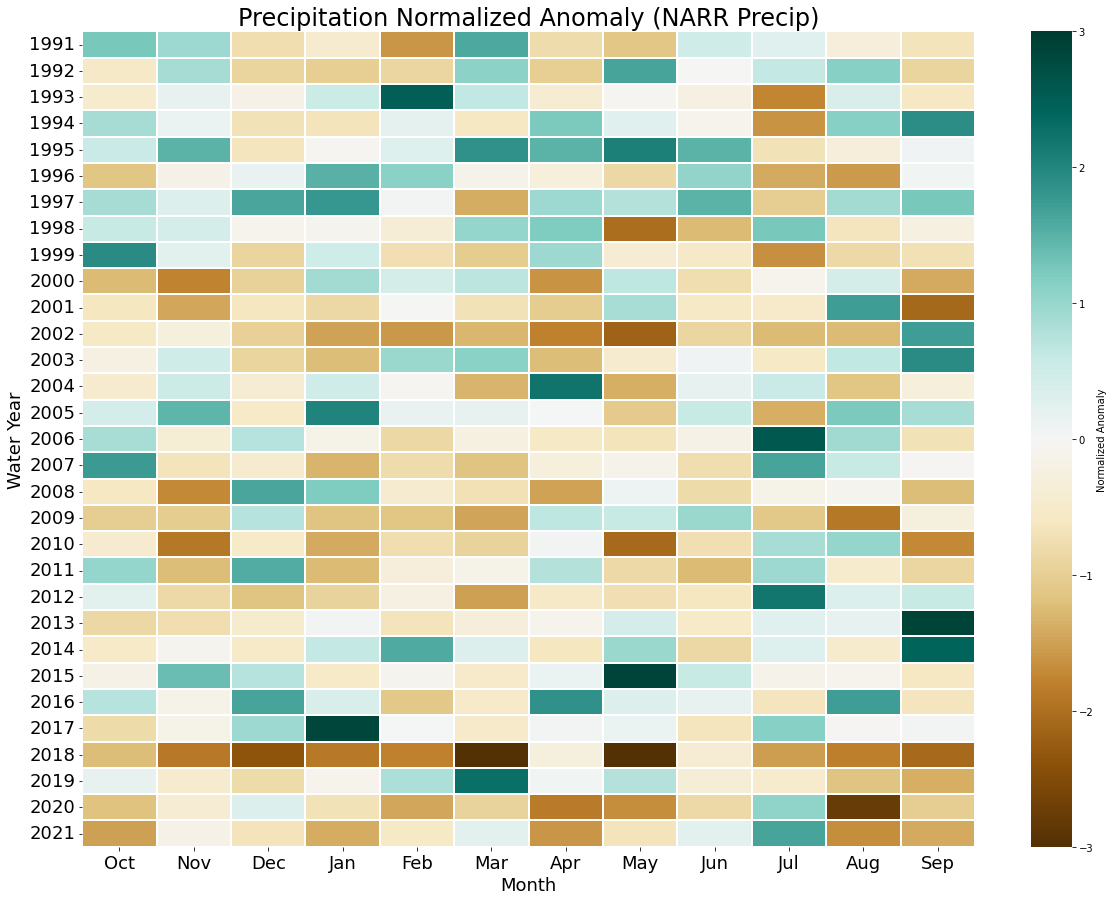

In [727]:
fig, ax=plt.subplots(figsize=(20,15), facecolor='w')
months = ['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep']
sns.heatmap(combined_anomaly_df, cmap='BrBG', vmin=-3, vmax=3,linewidths=2, cbar_kws={'label':'Normalized Anomaly'})
ax.set_yticklabels(combined_anomaly_df.index, rotation=0, ha='right', size=18);
ax.set_xticklabels(months, rotation=0, ha='center', size=18);
ax.set_xlabel('Month',size=18)
ax.set_ylabel('Water Year', size=18)
ax.set_title('Precipitation Normalized Anomaly (NARR Precip)', size=24)

Text(0.5, 1.0, 'Potential ET Normalized Anomaly (Taylor Park RAWS)')

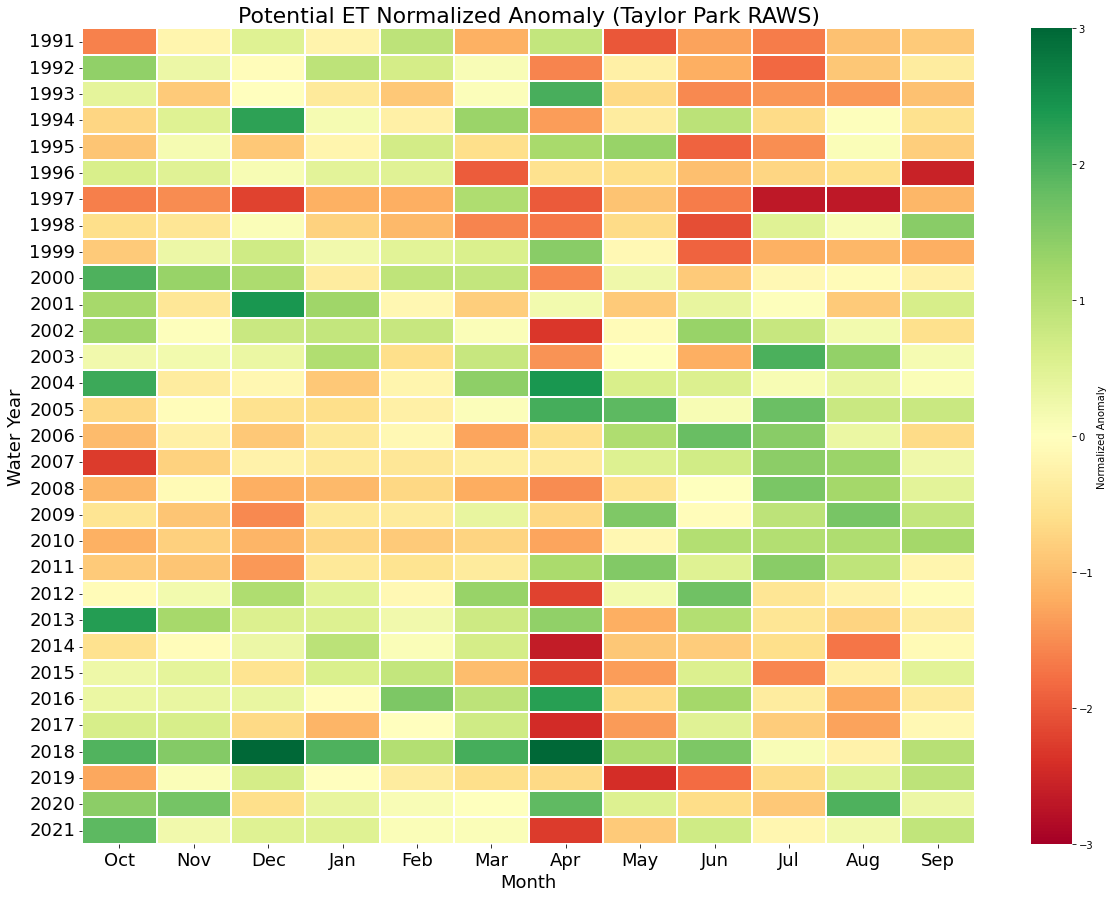

In [733]:
fig, ax=plt.subplots(figsize=(20,15), facecolor='w')

months = ['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep']
sns.heatmap(combined_anomaly_df, cmap='RdYlGn', vmin=-3, vmax=3,linewidths=2, cbar_kws={'label':'Normalized Anomaly'})
ax.set_yticklabels(combined_anomaly_df.index, rotation=0, ha='right', size=18);
ax.set_xticklabels(months, rotation=0, ha='center', size=18);
ax.set_xlabel('Month',size=18)
ax.set_ylabel('Water Year', size=18)
ax.set_title('Potential ET Normalized Anomaly (Taylor Park RAWS)', size=22)

Text(0.5, 1.0, 'Relative Humidity Normalized Anomaly (Taylor Park RAWS)')

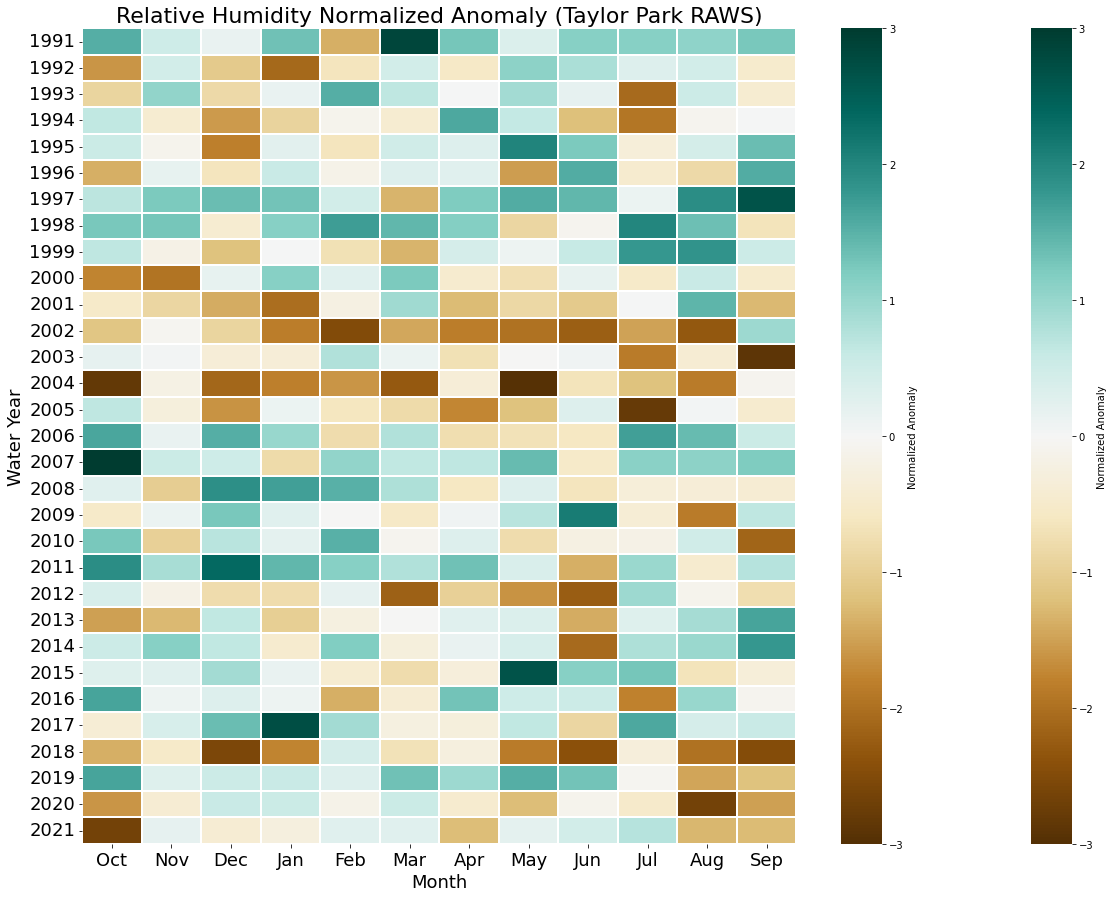

In [746]:
fig, ax=plt.subplots(figsize=(20,15), facecolor='w')

months = ['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep']
sns.heatmap(combined_anomaly_df[combined_anomaly_df<0], cmap='BrBG', vmin=-3, vmax=3,linewidths=2, cbar_kws={'label':'Normalized Anomaly'})
ax.set_yticklabels(combined_anomaly_df.index, rotation=0, ha='right', size=18);
ax.set_xticklabels(months, rotation=0, ha='center', size=18);
ax.set_xlabel('Month',size=18)
ax.set_ylabel('Water Year', size=18)
ax.set_title('Relative Humidity Normalized Anomaly (Taylor Park RAWS)', size=22)

In [774]:
# create index of warm, dry years, cold, wet years, warm wet years and cold dry months
warm_dry_months = combined_anomalies[(combined_anomalies['temp']>0) & (combined_anomalies['precip']<=0)] # negative - redish implies less water
warm_wet_months = combined_anomalies[(combined_anomalies['temp']>0) & (combined_anomalies['precip']>0)] # positive - greenish implie smore water/ET
cold_wet_months = combined_anomalies[(combined_anomalies['temp']<=0) & (combined_anomalies['precip']>0)] # negative - blueish implies more water
cold_dry_months = combined_anomalies[(combined_anomalies['temp']<=0) & (combined_anomalies['precip']<=0)] # positive - brownish implies less water


dfs = [warm_dry_months,warm_wet_months, cold_wet_months, cold_dry_months]
cold=[]
warm=[]
for year in wy.unique():
    # warm
    w1 = dfs[0][dfs[0]['wy'] == year]['temp'] * dfs[0][dfs[0]['wy'] == year]['precip']
    w2 = dfs[1][dfs[1]['wy'] == year]['temp'] * dfs[1][dfs[1]['wy'] == year]['precip']
    # cold
    c1= dfs[2][dfs[2]['wy'] == year]['temp'] * dfs[2][dfs[2]['wy'] == year]['precip']
    c2= dfs[3][dfs[3]['wy'] == year]['temp'] * dfs[3][dfs[3]['wy'] == year]['precip']

    w = pd.concat([w1,w2])
    w = w.groupby(w.index.month).mean()
    # w = w[idx]
    w.name=year
    warm.append(w)

    c = pd.concat([c1,c2])
    c = c.groupby(c.index.month).mean()
    # c = c[idx]
    c.name=year
    cold.append(c)

combined_warm_anomaly_df = pd.concat(warm, axis=1).T[[i for i in idx]]
combined_cold_anomaly_df = pd.concat(cold, axis=1).T[[i for i in idx]]

Text(0.5, 1.0, 'Signal of Warm/Cold & Wet/Dry Normalized Anomaly (Taylor Park RAWS)')

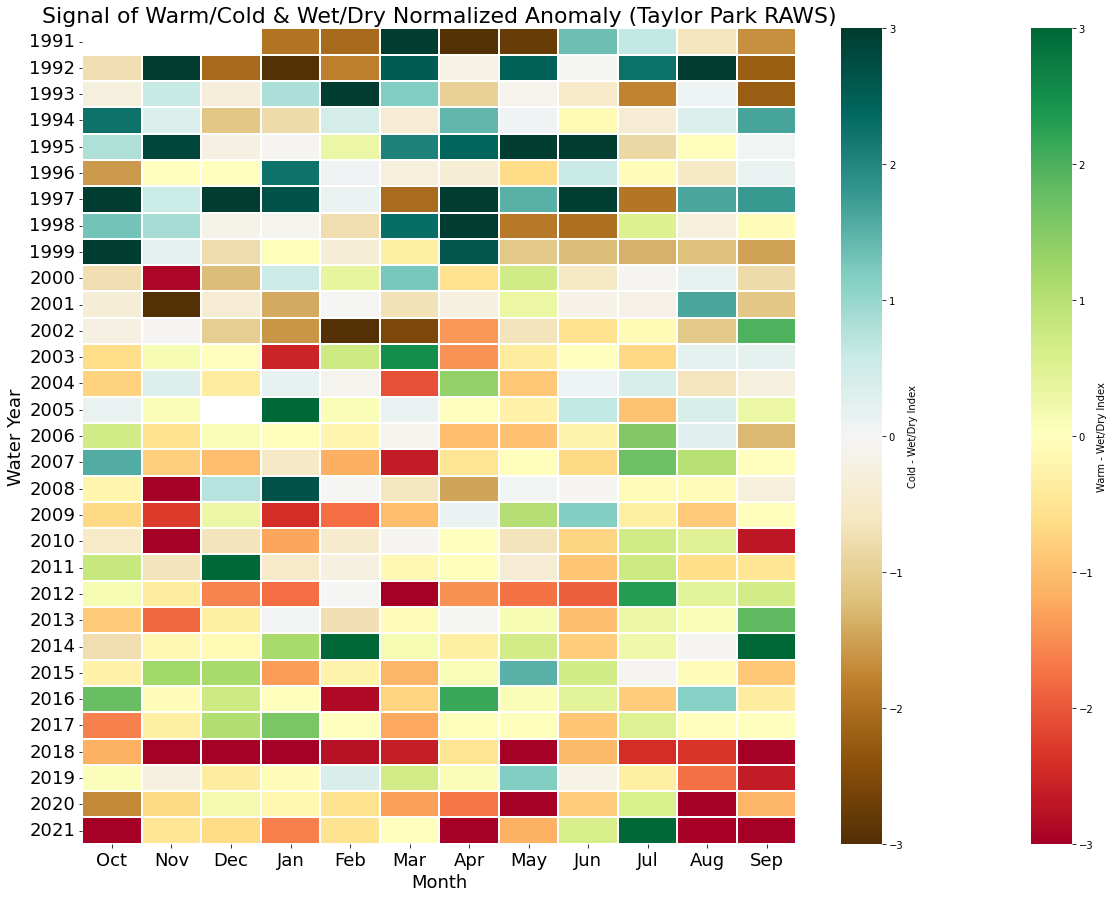

In [776]:
fig, ax=plt.subplots(figsize=(20,15), facecolor='w')

months = ['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep']
sns.heatmap(combined_warm_anomaly_df, cmap='RdYlGn', vmin=-3, vmax=3,linewidths=2, cbar_kws={'label':'Warm - Wet/Dry Index'})
sns.heatmap(-combined_cold_anomaly_df, cmap='BrBG', vmin=-3, vmax=3,linewidths=2, cbar_kws={'label':'Cold - Wet/Dry Index'})
ax.set_yticklabels(combined_anomaly_df.index, rotation=0, ha='right', size=18);
ax.set_xticklabels(months, rotation=0, ha='center', size=18);
ax.set_xlabel('Month',size=18)
ax.set_ylabel('Water Year', size=18)
ax.set_title('Signal of Warm/Cold & Wet/Dry Normalized Anomaly (Taylor Park RAWS)', size=22)

1991         NaN
1992    0.037938
1993   -0.734241
1994    0.104052
1995    0.716695
1996   -0.286377
1997    0.354354
1998   -0.189098
1999    0.347058
2000   -0.093075
2001    0.066653
2002   -0.425702
2003   -0.168199
2004   -0.029707
2005   -0.325182
2006    0.028000
2007    0.286950
2008   -0.556619
2009   -0.197236
2010    0.022383
2011    0.757082
2012   -0.118530
2013   -0.062161
2014    0.686025
2015    0.776363
2016    0.089227
2017   -0.128314
2018   -0.332815
2019    0.437554
2020   -0.558314
2021   -0.504764
dtype: float64

In [2]:
import act
import nctoolkit as nc

Please install CDO version 1.9.3 or above: https://code.mpimet.mpg.de/projects/cdo/ or https://anaconda.org/conda-forge/cdo
Please install CDO version 1.9.3 or above: https://code.mpimet.mpg.de/projects/cdo/ or https://anaconda.org/conda-forge/cdo


In [19]:
ds1 = nc.open_url('ftp://ftp.eol.ucar.edu/pub/archive/isfs/projects/SOS/netcdf/noqc_geo/isfs_20221212.nc').to_xarray()
ds2 = nc.open_url('ftp://ftp.eol.ucar.edu/pub/archive/isfs/projects/SOS/netcdf/noqc_geo/isfs_20221213.nc').to_xarray()
nc.clean_all()

In [20]:
import xarray as xr

ds = xr.concat([ds1,ds2], dim='time')

In [21]:
vars = list(ds.keys())
u_vars = []
v_vars = []
temp_vars = []
rh_vars = []
tsnow_vars = []
h2o_vars = []
Tsfc = []
for var in vars:
    if ('u_' in var) & ('c' in var) & (len(var) <= 7):
        u_vars.append(var)
    elif ('v_' in var) & ('c' in var) & (len(var) <= 7):
        v_vars.append(var)
    elif ('h2o_' in var) & ('c' in var) & (len(var) <= 9):
        h2o_vars.append(var)
    elif ('Tsnow' in var) & ('d' in var):
        tsnow_vars.append(var)
    elif 'T_' in var:
        temp_vars.append(var)
    elif 'RH_' in var:
        rh_vars.append(var)
    elif 'Vtherm' in var:
        Tsfc.append(var)

In [49]:
tsnow_vars

['Tsnow_0_4m_d',
 'Tsnow_0_5m_d',
 'Tsnow_0_6m_d',
 'Tsnow_0_7m_d',
 'Tsnow_0_8m_d',
 'Tsnow_0_9m_d',
 'Tsnow_1_0m_d',
 'Tsnow_1_1m_d',
 'Tsnow_1_2m_d',
 'Tsnow_1_3m_d',
 'Tsnow_1_4m_d',
 'Tsnow_1_5m_d']

In [22]:
ds_30min_avg = ds.resample(time='30min').mean()

In [23]:
df_u = ds_30min_avg[u_vars].to_pandas()
df_u = df_u[['u_1m_c','u_2m_c',	'u_3m_c',	'u_5m_c',	'u_10m_c','u_15m_c','u_20m_c']]

In [24]:
df_v = ds_30min_avg[v_vars].to_pandas()
df_v = df_v[['v_1m_c','v_2m_c','v_3m_c','v_5m_c',	'v_10m_c','v_15m_c','v_20m_c']]

In [25]:
atms_pressure = ds_30min_avg['P_10m_uw']

In [26]:
from natsort import natsorted

df_temp = ds_30min_avg[natsorted(temp_vars)].to_pandas()
df_tsnow = ds_30min_avg[natsorted(tsnow_vars)].to_pandas()
df_h2o = ds_30min_avg[natsorted(h2o_vars)].to_pandas()

In [27]:
temp_h2o = natsorted([var.replace('h2o','T') for var in h2o_vars])

In [28]:
R = 287 # specific gas constant for dry air in J K-1 kg-1
pressure_pa = 100*atms_pressure.to_pandas()
denom = 1/(R * (273.15+df_temp[temp_h2o]))
df_rho_air = denom.multiply(pressure_pa, axis=0)
df_q = (df_h2o/1000).rename(columns=dict(zip(df_h2o.columns, df_rho_air.columns))) / (df_rho_air + (df_h2o/1000).rename(columns=dict(zip(df_h2o.columns, df_rho_air.columns))))
df_q[df_q < 0] = 0

In [29]:
T_v = (273.15+df_temp[temp_h2o]) * (1 + 0.622*df_q)
virtual_potential_temp = T_v.multiply((1000/atms_pressure.to_pandas())**0.286, axis=0) - 273.15
virtual_potential_temp=virtual_potential_temp[['T_1m_c','T_2m_c','T_3m_c',	'T_10m_c','T_15m_c','T_20m_c']]


In [30]:
import numpy as np
Y=[1,2,3,5,10,15,20]
Y2 = np.arange(1,21,1)
y3=np.arange(0.4,1.51,0.1)
X=ds_30min_avg.time.to_numpy()

Virtual Potential temperature with height and wind speed

shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


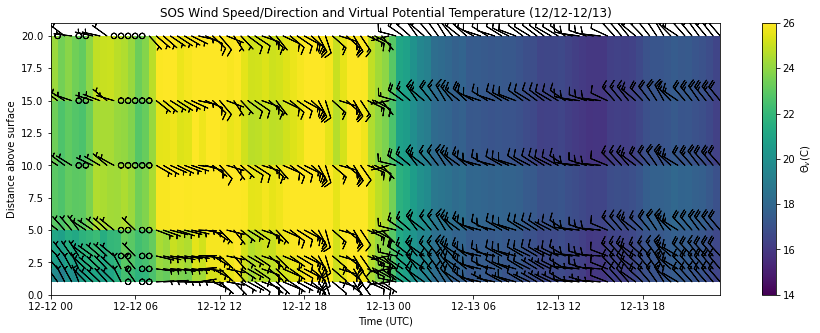

In [48]:
fig,ax = plt.subplots(figsize=(15,5))
mesh = ax.pcolormesh(X,Y, virtual_potential_temp.values.T, vmin=14, vmax=26)
# ax.pcolormesh(X,y3,df_tsnow.values.T,
#             cmap='coolwarm', vmin=-10, vmax=4)
ax.barbs(X,Y,df_u.values.T*2.237, df_v.values.T*2.237,
         length=6, )
        #  barb_increments={'half':1,
        #                 'full':5,
        #                 'flag':20})
ax.set_ylim(0,21)
# ax.set_xlim(dt.datetime(2022,11,5,0,0))
ax.set_xlabel('Time (UTC)')   
ax.set_ylabel('Distance above surface')
ax.set_title('SOS Wind Speed/Direction and Virtual Potential Temperature (12/12-12/13)')
fig.colorbar(mesh, ax=ax, label='$\Theta_v$(C)')                     


In [32]:
import matplotlib.pyplot as plt


shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


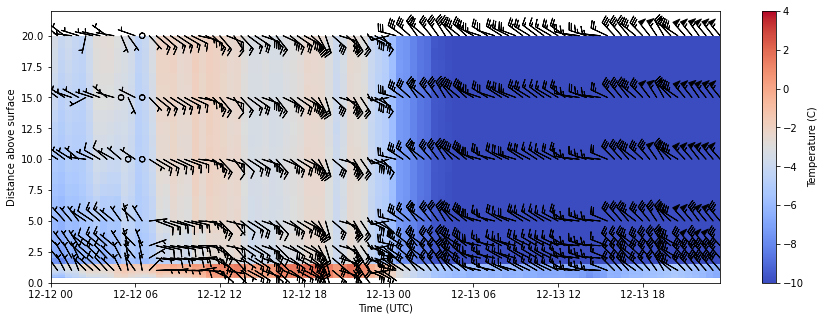

In [41]:
fig,ax = plt.subplots(figsize=(15,5))
mesh = ax.pcolormesh(X,Y2,df_temp.values.T,
            cmap='coolwarm',vmin=-10, vmax=4)
ax.pcolormesh(X,y3,df_tsnow.values.T,
            cmap='coolwarm', vmin=-15, vmax=0)
ax.barbs(X,Y,df_u.values.T*2.237, df_v.values.T*2.237,
         length=6, 
         barb_increments={'half':1,
                        'full':5,
                        'flag':20})
ax.set_ylim(0,22)
# ax.set_xlim(dt.datetime(2022,11,5,0,0))
ax.set_xlabel('Time (UTC)')   
ax.set_ylabel('Distance above surface')
fig.colorbar(mesh, ax=ax, label='Temperature (C)')    

In [1009]:
ds_30min_avg[Tsfc]

<xarray.Dataset>
Dimensions:    (time: 47)
Coordinates:
  * time       (time) datetime64[ns] 2022-12-08 ... 2022-12-08T23:00:00
Data variables:
    Vtherm_ue  (time) float32 1.506 1.514 1.517 1.522 ... 1.642 1.651 1.655
    Vtherm_uw  (time) float32 1.51 1.517 1.519 1.525 ... 1.637 1.646 1.654 1.66
    Vtherm_d   (time) float32 1.505 1.509 1.515 1.519 ... 1.636 1.638 1.646 1.65
    Vtherm_c   (time) float32 1.503 1.507 1.511 1.515 ... 1.636 1.639 1.647 1.65

In [1011]:
ds_30min_avg.Vpile_c

<xarray.DataArray 'Vpile_c' (time: 47)>
array([-4.04015955e-05, -3.54260192e-05, -4.47980565e-05, -6.53935349e-05,
       -3.42729909e-05, -4.28205276e-05, -3.34203360e-05, -4.88080550e-05,
       -3.08513518e-05, -1.08273298e-05, -1.55427606e-05, -2.52231966e-05,
       -2.23199404e-05, -1.80840070e-05, -1.57714239e-05, -1.25771485e-05,
       -1.27975363e-05, -1.52623779e-05, -1.53726523e-05, -1.47691790e-05,
       -6.05414743e-06, -7.87775207e-06, -5.57838166e-06, -1.69265934e-06,
       -1.36268784e-06, -4.56261841e-06, -9.03720775e-06, -9.71168902e-06,
       -1.71972861e-05, -1.55276939e-05, -1.33163267e-05, -2.06007699e-05,
       -2.62026388e-05, -3.14461759e-05, -3.57317476e-05, -2.66938350e-05,
       -3.90643290e-05, -4.75639426e-05, -6.04587585e-05, -7.05887869e-05,
       -7.59065952e-05, -7.77882087e-05, -8.44361130e-05, -8.95831108e-05,
       -8.84332039e-05, -9.61938422e-05, -9.37068980e-05], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2022-12-08 ... 2022-12-08T23:00:00

In [1010]:
import numpy as np

In [1018]:

ID = ds_30min_avg.IDir_c.values
sns = [136, 137, 138, 139]
im = [ sns.index(x) if x in sns else None for x in ID ][0]
# unclear if we want these, or scaled up versions
mC0 = [57508.575,56653.007,58756.588,58605.7861][im]
mC1 = [289.12189,280.03380,287.12487,285.00285][im]
mC2 = [2.16807,2.11478,2.11822,2.08932][im]
bC0 = [-168.3687,-319.9362,-214.5312,-329.6453][im]
bC1 = [-0.22672,-1.23812,-0.59308,-1.24657][im]
bC2 = [0.08927,0.08612,0.10936,0.09234][im]

In [1045]:
# Implement the Apogee SIF-111 manual procedure to calculate Tsfc from it
# I am not sure if it is robust to reading multiple sensors
#
# dat.Tsfc.Ap = function(what,...)
# {
def apogee2temp(dat,tower):
# hard-coded sensor-specific calibrations
    Vref = 2.5
    ID = dat[f"IDir_{tower}"].values
    sns = [136, 137, 138, 139]
    im = [ sns.index(x) if x in sns else None for x in ID ][0]
# unclear if we want these, or scaled up versions
    mC0 = [57508.575,56653.007,58756.588,58605.7861][im]
    mC1 = [289.12189,280.03380,287.12487,285.00285][im]
    mC2 = [2.16807,2.11478,2.11822,2.08932][im]
    bC0 = [-168.3687,-319.9362,-214.5312,-329.6453][im]
    bC1 = [-0.22672,-1.23812,-0.59308,-1.24657][im]
    bC2 = [0.08927,0.08612,0.10936,0.09234][im]
# read data
    Vtherm = dat[f"Vtherm_{tower}"].values
    Vpile = dat[f"Vpile_{tower}"].values
# calculation of detector temperature from Steinhart-Hart
    Rt = 24900.0/((Vref/Vtherm) - 1)
    Ac = 1.129241e-3
    Bc = 2.341077e-4
    Cc = 8.775468e-8
    TDk = 1/(Ac + Bc*np.log(Rt) + Cc*(np.log(Rt)**3))
# finally, calculation of "target" temperature including thermopile measurement
    m = mC2*TDk**2 + mC1*TDk + mC0
    b = bC2*TDk**2 + bC1*TDk + bC0
    TTc = (TDk**4 + m*Vpile + b)**0.25 - 273.15
    # sufs = suffixes(TTc,leadch='') # get suffixes
    # dimnames(TTc)[[2]] = paste0("Tsfc.Ap.",sufs)
    TTc = TTc * units('celsius')
    return TTc


In [1046]:
apogee2temp(ds_30min_avg,'c')

Magnitude,[-2.718963623046875 -2.8399658203125 -2.9652099609375 -3.0831298828125 -3.111053466796875 -2.891510009765625 -3.016143798828125 -3.264190673828125 -3.9268798828125 -3.68890380859375 -3.5362548828125 -3.566314697265625 -4.040435791015625 -4.69781494140625 -4.239654541015625 -3.5592041015625 -4.034942626953125 -4.893829345703125 -5.753662109375 -6.212799072265625 -6.9168701171875 -7.2342529296875 -7.572998046875 -7.973419189453125 -8.10797119140625 -7.938873291015625 -7.572418212890625 -7.7537841796875 -7.66253662109375 -7.62066650390625 -7.65618896484375 -7.226898193359375 -6.888824462890625 -6.845458984375 -6.409454345703125 -6.346710205078125 -5.872833251953125 -6.16815185546875 -6.13470458984375 -5.65753173828125 -4.87213134765625 -4.55914306640625 -6.01385498046875 -7.0311279296875 -7.123626708984375 -7.39044189453125 -7.51678466796875]
Units,degree_Celsius


In [93]:
# Compare surface temperatures 


NameError: name 'ds_30min_avg' is not defined